# Ajuste-fino da Arquitetura do Modelo e Hiperparâmetros RP

Com o estudo anterior (17), consolidamos a melhor `Taxa de Amostragem (= 5)` e o melhor `Tamanho de Janela` para cada aparelho da `residência 3` na base REDD.

Apesar de resultados satisfatórios, o processo de otimização considerou um pipeline canônico, escolhido aleatoriamente, composto de:
* Um conversor de séries em imagens baseado em Gráfico de Recorrência;
* Um modelo classificador baseado em CNN.

Neste sentido, a adoção de uma estratégia sistemática para escolha da arquitetura do modelo classificador e explotar diferentes combinações de hiperparâmetros do Gráfico de recorrência tendem a culminar em resultados de ponta para a identificação de cargas.

Portanto, neste estudo temos os seguintes objetivos:
1. Construir um modelo baseado em Deep Learning utilizando um arcabouço sistemático;
2. Varrer um conjunto discreto de valores combinatórios dos hiperparâmetros do RP.

# Configurações

In [1]:
import os
import sys
import gc
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

# TODO: implementar rotina na classe PyNILM.utils
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def listar_variaveis_memoria(ambiente):
    print("* Variáveis instanciadas em memória:")
    print("---")
    total = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in ambiente.items()),
                             key= lambda x: -x[1])[:10]:
        total += size
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    print("---")
    print("Total:", sizeof_fmt(total))
    
# TODO: implementar na classe utils
def highlight_col(x):
    r = 'background-color: #D9D9D9'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, -2] = r
    return df1   

In [2]:
# CONSTANTES FUNDAMENTAIS DE ORGANIZACAO DE PASTAS/ARQUIVOS

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "18") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK)
caminho_redd = os.path.join(caminho_dados, "REDD/low_freq")

# Path completo do arquivo REDD
arquivo_dataset = os.path.join(caminho_redd, "redd.h5")

# VARIAVEL AUXILIAR
# Path dos arquivos relacionados as janelas
caminho_janelas = os.path.join(caminho_redd, "../../phd")
if not os.path.isdir(caminho_janelas):
    os.makedirs(caminho_janelas)

# Dados

## Base REDD

In [3]:
# Exemplo de carregamento da base REDD no NILMTK
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.dataset_converters import convert_redd

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from PyNILM.dados.janelas import Janelas

# Gerar arquivo H5 (Nilmtk) do dataset REDD, caso n exista
if not os.path.isfile(arquivo_dataset):
    print("Gerando arquivo H5 (NILMTK) da base REDD, aguarde...")
    print("-----")
    convert_redd(caminho_redd, arquivo_dataset)

# Carregando dataset REDD no objeto NILMTK
redd = DataSet(arquivo_dataset)
print("NILMTK -> Detalhes sobre o dataset REDD:")
print_dict(redd.metadata)
print()

# Parametros dos dados
PARAMETROS_DATASET = {
    "base":redd,
    "id_residencia":3,
    "inicio_intervalo":'2011-04-16 05:11:30',
    "fim_intervalo":'2011-04-23 08:43:26',
    "debug": False    
}
print("PARÂMETROS DO ESTUDO:")
pprint(PARAMETROS_DATASET)

NILMTK -> Detalhes sobre o dataset REDD:



PARÂMETROS DO ESTUDO:
{'base': <nilmtk.dataset.DataSet object at 0x00000207DC3A06D8>,
 'debug': False,
 'fim_intervalo': '2011-04-23 08:43:26',
 'id_residencia': 3,
 'inicio_intervalo': '2011-04-16 05:11:30'}


In [4]:
def carregar_dados_aparelho(janelas, instancia, aparelho, taxa, tamanho_janela, split_teste=None):
    # Extrair series divididas em janelas para cada medidor
    dados_cargas = janelas.preparar(
        taxa_amostral=taxa, 
        intervalo_medicao=tamanho_janela
    )
    print()

    # Pprearando dados (Serie / Estado)
    # X
    dados_medidores = janelas.filtrar_cargas(
        dados_cargas,
        filtros=[
            (1, 'site_meter'),
            (2, 'site_meter'),    
        ]
    )
    X = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]

    # y
    dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(instancia, aparelho)])[0]
    y = dados_aparelho["rotulos"]["estado"]

    # <<< Limpando memoria >>>
    dados_cargas = None
    del dados_cargas
    dados_medidores = None
    del dados_medidores
    dados_aparelho = None
    del dados_aparelho
    gc.collect()
    # <<< Limpando memoria >>>

    # Fazendo split dos dados (treino/teste)
    if split_teste is None:
        return X, y
    else:
        X_treino, X_teste, y_treino, y_teste = train_test_split(
            X, y, 
            test_size=split_teste,
            stratify=y,
            random_state=SEED
        )
        print()

        return X_treino, X_teste, y_treino, y_teste        
        

## Melhores Janelas para cada aparelho (estudo 17)

In [5]:
df_melhores_janelas = pd.read_csv(os.path.join(caminho_dados, "17", "taxa_5-melhoresjanelas.csv"))
df_melhores_janelas

,taxa_amostragem,carga,janela,loss,acuracia,f1_macro
0,5,sockets - 3,1080,0.103,93.10,73.15
1,5,sockets - 4,30,0.000,100.00,100.00
2,5,light - 5,1080,0.018,100.00,100.00
3,5,ce_appliance - 6,360,0.000,100.00,100.00
4,5,fridge - 7,360,0.000,100.00,100.00
5,5,waste_disposal_unit - 8,30,0.099,99.81,49.95
6,5,dish_washer - 9,60,0.092,97.67,74.40
7,5,electric_furnace - 10,30,1.154,90.70,82.94
8,5,light - 11,30,7.155,82.76,79.20
9,5,sockets - 12,30,2.086,85.96,67.43


# Validação da Metodologia e Arquitetura Desenvolvida
---

Nesta etapa, iremos:

1. Otimizar os hiperparâmetros do RP em função de cada aparelho;
2. Considerando apenas um aparelho dentre os cinco adotados no paper IEEE - o qual será escolhido com base no pior desempenho obtido no estudo anterior - iremos validar a arquitetura de DL adotada, de modo a verificar a viabilidade de melhoria dos resultados.

## Ambiente e Funções Auxiliares

### Preparando ambiente de desenvolvimento 

In [6]:
# from PyNILM.dados.janelas import Janelas

from PyNILM.avaliacao.metricas import *
from PyNILM.avaliacao.graficos import *
from PyNILM.avaliacao.analises import *

from sklearn.model_selection import train_test_split

from pyts.image import RecurrencePlot

import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPool1D
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import backend as K
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


from pyts.image import RecurrencePlot, GramianAngularField

# Garantindo reprodutibilidade
import random as rn
# Constantes dos experimentos
SEED = 33
FRACAO_TESTE = 0.25
EPOCAS = 100
TAMANHO_LOTE = 32
VERBOSIDADE = 2
PARAMETROS_RP = {
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}
TAMANHO_IMAGEM = (32,32)
# PARAMETROS_RP={
#     "dimension": 3,
#     "time_delay": 8,
#     "threshold": 0.1
# }
# Travar Seed's
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(SEED)
rn.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)

# Habilitando/limitando utilização de GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*5)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("# GPUs habilitadas:", "{} física(s)".format(len(gpus)), "/", "{} lógica(s)".format(len(gpus)))
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# GPUs habilitadas: 1 física(s) / 1 lógica(s)


### Rotinas da Etapa de Modelagem de DL

In [7]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, \
                    Dropout, MaxPool2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.constraints import max_norm
from sklearn.utils import class_weight

def convnet(
    loss_function = 'binary_crossentropy', 
    optimizer='adam',
    metrics=['accuracy'],
    bias_output = 0,
):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(32,32,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(1, activation="sigmoid",
                    bias_initializer=tf.keras.initializers.Constant(bias_output), 
                    name="output"))

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
    
    return model

def convnet2(
    loss_function = 'binary_crossentropy', 
    optimizer='adam',
    metrics=['accuracy'],
    bias_output = 0,
):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_uniform', input_shape=(32,32,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation='relu', kernel_initializer = 'he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer = 'he_uniform'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation="sigmoid",
                    bias_initializer=tf.keras.initializers.Constant(bias_output), 
                    name="output"))

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
    
    return model


def modelo_baseline(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'], 
    bias_output = 0,
    name="Baseline"
):
    tf.random.set_seed(SEED)
    
    model = Sequential(name=name)

    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="valid", kernel_initializer = 'he_uniform', input_shape=(32,32,1), kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    model.add(AveragePooling2D())
    #model.add(MaxPool2D())
    
    model.add(Conv2D(128, kernel_size=(3,3), padding="valid", kernel_initializer='he_uniform', kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    model.add(AveragePooling2D())
    #model.add(MaxPool2D())
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))

    model.add(Dense(128))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    #model.add(Dropout(0.2))
 
    # Output
    model.add(Dense(1, activation='sigmoid', 
                    bias_initializer=tf.keras.initializers.Constant(bias_output), 
                    name="output"))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model


def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.

      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)

      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.

    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)

    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) \
               -K.mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))

    return binary_focal_loss_fixed


def modelo_baseline2(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'], 
    bias_output = 0,
    name="Baseline"
):
    tf.random.set_seed(SEED)
    
    model = Sequential(name=name)

    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="valid", kernel_initializer = 'he_uniform', input_shape=(32,32,1), kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    model.add(AveragePooling2D())
    #model.add(MaxPool2D())
    
    model.add(Conv2D(128, kernel_size=(3,3), padding="valid", kernel_initializer = 'he_uniform', kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    model.add(AveragePooling2D())
    #model.add(MaxPool2D())
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))

    model.add(Dense(128))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    #model.add(Dropout(0.2))
 
    # Output
    model.add(Dense(1, activation='sigmoid', 
                    bias_initializer=tf.keras.initializers.Constant(bias_output), 
                    name="output"))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

# # from PyNILM.dados.janelas import Janelas

# from PyNILM.avaliacao.metricas import *
# from PyNILM.avaliacao.graficos import *
# from PyNILM.avaliacao.analises import *

# from sklearn.model_selection import train_test_split

### Rotinas do Gráfico de Recorrências

In [8]:
# Construindo o pipeline de dados
# ----------

import cv2

# Constante fundamentais
TAMANHO_IMAGEM = (32,32,1) # Apenas 1 canal
TIPO_DADOS = np.float32
def serie_para_imagem(serie, params_rp = PARAMETROS_RP, tam_imagem=TAMANHO_IMAGEM, centralizar=False, normalizar=False):
    """
    Funcao responsavel por gerar e tratar a imagem RP (baseado estudo #17).
    """
    # Gerando imagem RP/redimensionando
    imagem = RecurrencePlot(**params_rp).fit_transform([serie])[0]
    imagem = cv2.resize(
            imagem, 
            dsize=tam_imagem[:2], 
            interpolation=cv2.INTER_CUBIC
        ).astype(TIPO_DADOS)
    
#     # Normalizar
#     if normalizar:
#         #imagem = (imagem - imagem.min()) / (imagem.max() - imagem.min()) # MinMax (0,1)
#         imagem = (imagem - imagem.mean()) / np.max([imagem.std(), 1e-4])
        
    # N canais
    imagem = np.stack([imagem for i in range(tam_imagem[-1])],axis=-1).astype(TIPO_DADOS) 
    
    # centralizar
    if centralizar:
        imagem -= imagem.mean()
        
    # Normalizar
    if normalizar:
        imagem /= imagem.std()#tf.image.per_image_standardization(imagem).numpy()
    
    return imagem

def preparar_amostras(X, y, params_rp=PARAMETROS_RP, tam_imagem=TAMANHO_IMAGEM, centralizar=False, normalizar=False):
    X_imagem = np.empty((len(X), *TAMANHO_IMAGEM))
    for i, x in tqdm_notebook(enumerate(X), total=len(X)):
        X_imagem[i,] = serie_para_imagem(
            x, 
            params_rp=PARAMETROS_RP, 
            tam_imagem=TAMANHO_IMAGEM,
            centralizar=centralizar,
            normalizar=normalizar
        )
    return X_imagem, y

def preparar_amostra_tfdata(amostra, rotulo):
    """
    Preparação da amostra/rótulo para o modelo.
    """
    # Convertendo serie para imagem
    amostra = tf.numpy_function(serie_para_imagem, [amostra], TIPO_DADOS)
    amostra = tf.reshape(amostra, TAMANHO_IMAGEM)
    return amostra, rotulo

In [9]:
from nolitsa import delay, dimension, utils    

def obter_delay_autocorrelacao(x):
    # Compute autocorrelation and delayed mutual information.
    try:
        if np.unique(x).shape[0] > 1:
            r = delay.acorr(x, maxtau=x.shape[0])
            r_delay = np.argmax(r < 1.0 / np.e)
        else:
            r_delay = 1
    except:
        r_delay = 1
    finally:
        return r_delay

def dimensoes_validas(serie, dimensoes, delay, maxnum=None):
    """
    Baseado em:
        (linha 97 - https://github.com/manu-mannattil/nolitsa/blob/master/nolitsa/dimension.py); e
        (linha 165 - https://github.com/manu-mannattil/nolitsa/blob/master/nolitsa/utils.py)
    """
    
    
    if not maxnum:
        maxnum = (delay + 1) + 1 + (delay + 1)
    else:
        maxnum = max(1, maxnum)
        
    d = []
    comprimento_serie = len(serie)
    for dimensao in (dimensoes):
        # Reconstrucao do espaço de fases, se viavel
        try:
            y = utils.reconstruct(serie[:-delay], dimensao, delay)
            if maxnum < len(y):
                d.append(dimensao)
        except:
            pass
    return d

def obter_dimensao_falsosvizinhos(serie, dimensoes_avaliacao, delay, metrica="euclidean"):
    
    try: 
        f1, f2, f3 = dimension.fnn(
            serie, 
            tau=delay, 
            dim=dimensoes_avaliacao, 
            window=delay, 
            metric=metrica
        ) 
        embedding_dimension = f3.argmin()+1
    except:
        embedding_dimension = 1
    finally:
        return embedding_dimension
    
def k_valores_mais_frequentes(valores, k=10, ascendente=True):
    ordernado = sorted(Counter(valores).most_common(k), key=lambda tup: tup[0])
    counter_ordenado = sorted(ordernado, key=lambda tup: tup[1], reverse=True)
    return counter_ordenado

## Otimização de Hiperpâmetros de RP (por Aparelho) e Escolha do Aparelho

In [10]:
# Intervalo de tempo e residencia considerados na base REDD
janelas = Janelas(**PARAMETROS_DATASET)

In [ ]:
###################################################################
#                                                                 #  
#              <<< CELULA ABAIXO JA EXECUTADA!! >>>               #
#                                                                 #
###################################################################

* `FRIDGE - 7` / taxa=5 e janela=360 / f1=100.0...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {1: 266, 0: 77} (índice de equilíbrio = 28.95%)

   - Avaliando dimensao (embedding), atraso (delay) e margem (percentage/threshold) por amostra...




   - Avaliando as melhores configurações encontradas...


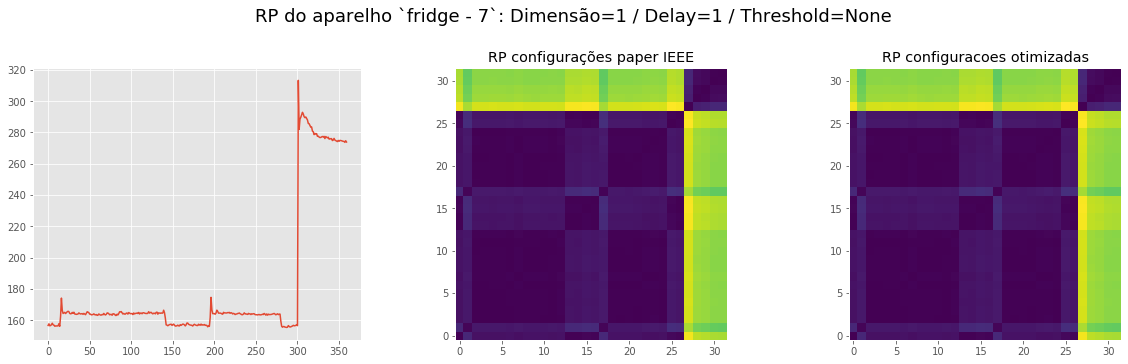

   -> Parâmetros otimizados do RP para o aparelho: {'dimension': 1, 'time_delay': 1, 'threshold': None}

* `DISH_WASHER - 9` / taxa=5 e janela=60 / f1=74.4...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {0: 2031, 1: 27} (índice de equilíbrio = 1.33%)

   - Avaliando dimensao (embedding), atraso (delay) e margem (percentage/threshold) por amostra...




   - Avaliando as melhores configurações encontradas...


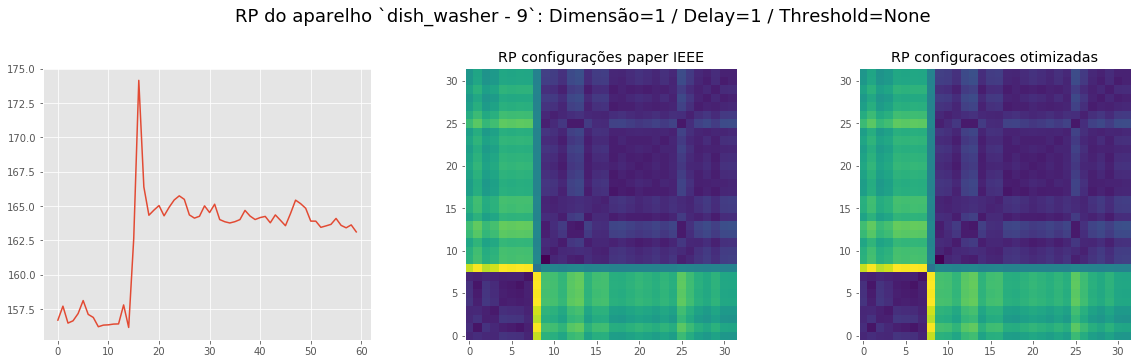

   -> Parâmetros otimizados do RP para o aparelho: {'dimension': 1, 'time_delay': 1, 'threshold': None}

* `WASHER_DRYER - 13` / taxa=5 e janela=60 / f1=92.11...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {0: 2011, 1: 47} (índice de equilíbrio = 2.34%)

   - Avaliando dimensao (embedding), atraso (delay) e margem (percentage/threshold) por amostra...




   - Avaliando as melhores configurações encontradas...


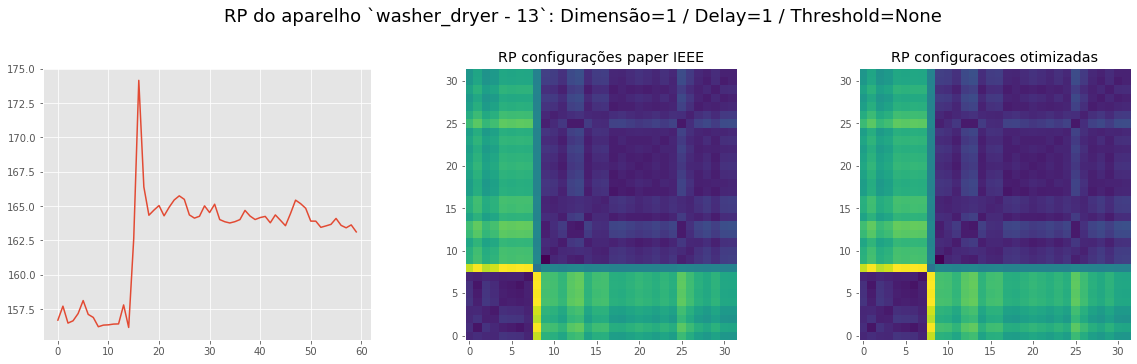

   -> Parâmetros otimizados do RP para o aparelho: {'dimension': 1, 'time_delay': 1, 'threshold': None}

* `WASHER_DRYER - 14` / taxa=5 e janela=30 / f1=82.88...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {0: 3988, 1: 128} (índice de equilíbrio = 3.21%)

   - Avaliando dimensao (embedding), atraso (delay) e margem (percentage/threshold) por amostra...




   - Avaliando as melhores configurações encontradas...


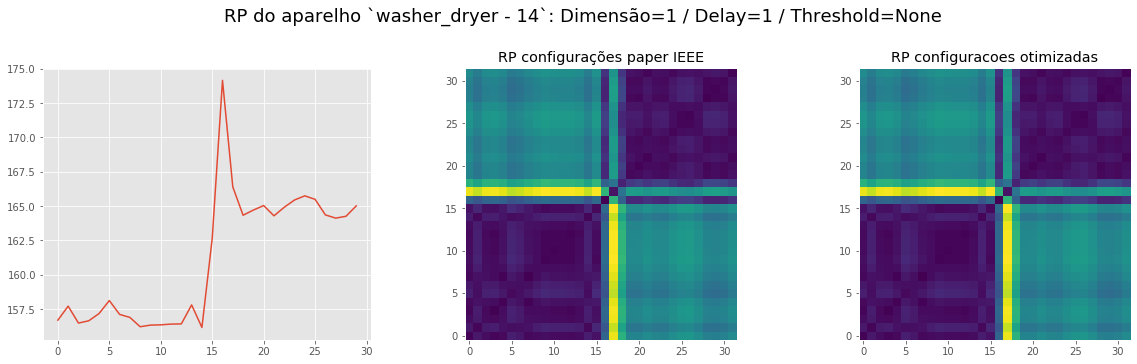

   -> Parâmetros otimizados do RP para o aparelho: {'dimension': 1, 'time_delay': 1, 'threshold': None}

* `MICROWAVE - 16` / taxa=5 e janela=30 / f1=71.23...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {0: 4071, 1: 45} (índice de equilíbrio = 1.11%)

   - Avaliando dimensao (embedding), atraso (delay) e margem (percentage/threshold) por amostra...




   - Avaliando as melhores configurações encontradas...


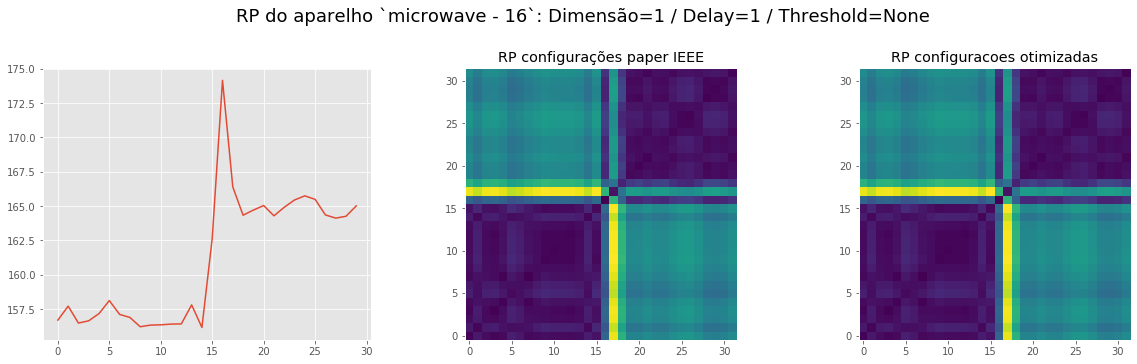

   -> Parâmetros otimizados do RP para o aparelho: {'dimension': 1, 'time_delay': 1, 'threshold': None}



In [13]:
# Escolhendo aparelho (conforme enunciado)
# -------------------
parametros_rp_aparelho = {}

# 1) Para cada aparelho dos considerados no paper IEE GM
for i, r in df_melhores_janelas.loc[
    (df_melhores_janelas["carga"].isin([
                "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"
            ])), :
].iterrows():
    
    # Informacoes da carga (nome, id, taxa e janela)
    carga = r["carga"].split(" - ")[0]
    instancia = int(r["carga"].split(" - ")[1])
    taxa = r["taxa_amostragem"]
    janela = r["janela"]
    print(f"* `{r['carga'].upper()}` / taxa={taxa} e janela={janela} / f1={r['f1_macro']}...")
          
    # 2) Carregar dados e verificar distribuição DA CARGA / JANELA
    
    # Extrair series divididas em janelas para cada medidor
    dados_cargas = janelas.preparar(taxa_amostral=taxa, intervalo_medicao=janela)
    print()
    #break
    
    # Escolhendo apenas dados do aparelho
    dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(instancia, carga)])
    # Analise dos dados
    distribuicao = dict(Counter(dados_aparelho[0]["rotulos"]["estado"]))
    maioritaria = max(distribuicao, key=distribuicao.get)
    minoritaria = 1 - maioritaria
    print(
        "  -> Distribuição:", distribuicao, 
        "(índice de equilíbrio = {:.2f}%)".format(
            (distribuicao[minoritaria]/distribuicao[maioritaria])*100
        )
    )
    print()

    print("   - Avaliando dimensao (embedding), atraso (delay) e margem (percentage/threshold) por amostra...")
    melhores_dimensoes, melhores_atrasos, melhores_thresholds = [], [], []
    X = dados_cargas[0]["janelas"] + dados_cargas[1]["janelas"] # Medidores
    # break
    for x in tqdm_notebook(X):
        try:
            
            # Delay, via Autocorrelação
            atraso = obter_delay_autocorrelacao(x)
            melhores_atrasos.append(atraso)
            #print(r'time delay = %d' % time_delay)
            # Dimensao, via Falsos Vizinhos
            dimensao = obter_dimensao_falsosvizinhos(
                serie=x, 
                dimensoes_avaliacao=dimensoes_validas(x, np.arange(1, 10 + 1), atraso),
                delay=atraso,
                metrica="euclidean"
            )
            melhores_dimensoes.append(dimensao)
            #print(r'dimension = %d' % dimension_embedding)
          
            # Trehsolds, em funcao do desvio da serie
            melhores_thresholds.append(np.floor((x.std()//2)/x.max() * 100).astype(np.int16))
          
        except Exception as e:
            #print(str(e))
            pass
    print()

    # Percorrer aparelhos
    print("   - Avaliando as melhores configurações encontradas...")
    for dimensao in k_valores_mais_frequentes(melhores_dimensoes, k=10):
        validado = False
        if dimensao[0]>0:
            for atraso in k_valores_mais_frequentes(melhores_atrasos, k=10):
                if atraso[0] > 0:
                    for threshold in  k_valores_mais_frequentes(melhores_thresholds, k=10):
                        if threshold[0] > 0:
                            rp_otimizado_aparelho = {
                                'dimension': dimensao[0], 
                                'time_delay': atraso[0],
                                'threshold': None,
                                #'percentage': 10
                                #'threshold': 'distance', # Selection of recurrence threshold for signal detection
                                #'percentage': 10#threshold[0] # Selection of recurrence threshold for signal detection
                            }
                            # Verificar viabilidade
                            try:
                                fig, axes = plt.subplots(1,3, figsize=(20,5))

                                x_ = X[0]
                                axes[0].plot(np.arange(len(x_)), x_)

                                axes[1].imshow(serie_para_imagem(x_)[:,:,0], origin="lower")
                                axes[1].set_title("RP configurações paper IEEE")
                                axes[1].grid(False)

                                axes[2].imshow(
                                    serie_para_imagem(x_, params_rp=rp_otimizado_aparelho#{'dimension': 3, 'time_delay': 10,'threshold': 0.25}
                                    )[:,:,0], origin="lower")
                                axes[2].set_title("RP configuracoes otimizadas")
                                axes[2].grid(False)

                                fig.suptitle("RP do aparelho `{}`: Dimensão={} / Delay={} / Threshold={}".format(
                                    r["carga"],
                                    rp_otimizado_aparelho["dimension"],
                                    rp_otimizado_aparelho["time_delay"],
                                    rp_otimizado_aparelho["threshold"],
                                ), size=18, y=1.05);
                                plt.show()

                                validado = True

                                # Adicionar condiguracao do aparelho
                                parametros_rp_aparelho[r["carga"]] = rp_otimizado_aparelho

                                break

                            except Exception as e:
                                #print("# Parametros inviáveis:", str(e))
                                pass
                if validado:
                    break
        if validado:
            break
    print("   -> Parâmetros otimizados do RP para o aparelho:", parametros_rp_aparelho[r["carga"]])
    print()

# Persistindo configuracoes
with open(os.path.join(caminho_dados_notebook, "parametros_rp_aparelho.json"), 'w') as arquivo:
    json.dump(parametros_rp_aparelho, arquivo)

In [20]:
print("* Parâmetros do RP otimizados por aparelho (janelas):")
print("---")
pprint(parametros_rp_aparelho)

* Parâmetros do RP otimizados por aparelho (janelas):
---
{'dish_washer - 9': {'dimension': 1, 'threshold': None, 'time_delay': 1},
 'fridge - 7': {'dimension': 1, 'threshold': None, 'time_delay': 1},
 'microwave - 16': {'dimension': 1, 'threshold': None, 'time_delay': 1},
 'washer_dryer - 13': {'dimension': 1, 'threshold': None, 'time_delay': 1},
 'washer_dryer - 14': {'dimension': 1, 'threshold': None, 'time_delay': 1}}


In [ ]:
###################################################################
#                                                                 #  
#                 <<< CELULA ACIMA JA EXECUTADA >>>               #
#                                                                 #
###################################################################

**NOTAS:** 
- A otimização dos parâmetros do RP validou  as escolhas utilizada no paper IEEE;
- será selecionado o aparelho `MICROWAVE - 16`, dado que este é o que possui o menor desempenho considerando o f1-score (macro).

## Preparando Dados do Aparelho Selecionado 

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

   - Avaliação de 5 amostras (OFF/ON)...
-----


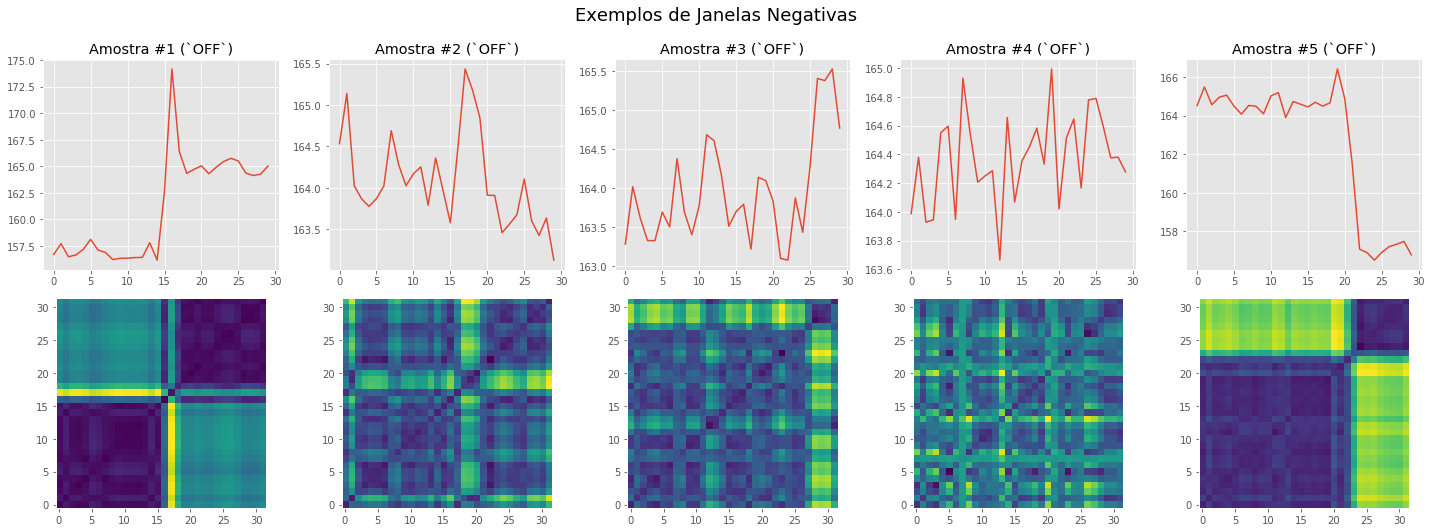

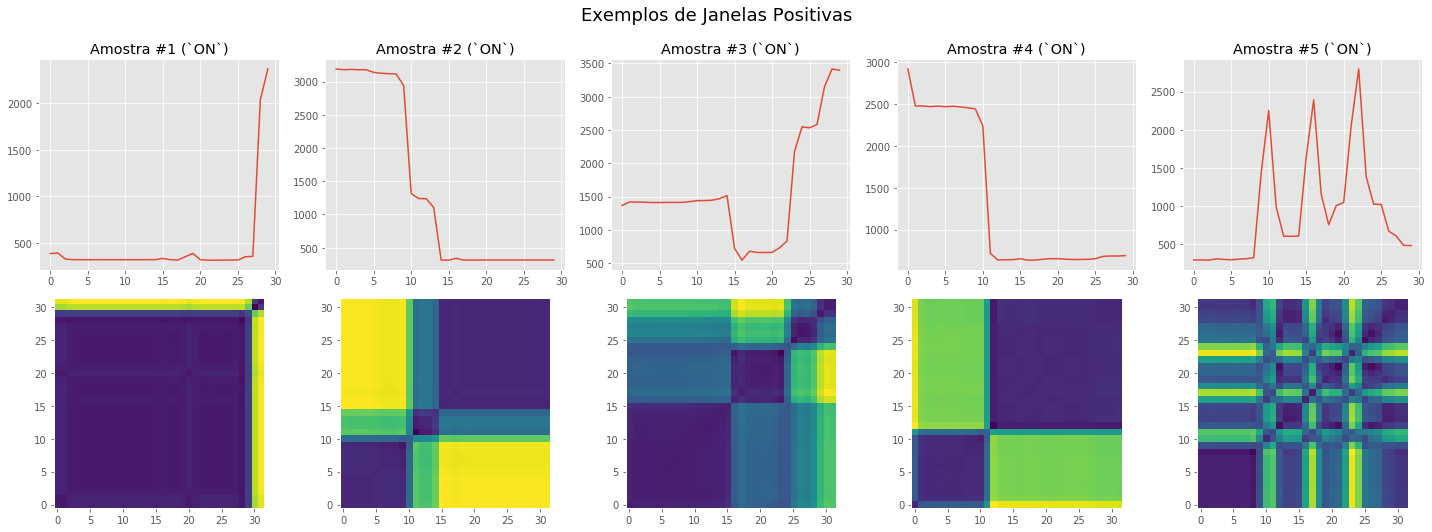

In [214]:
# Carregando arquivos de parametros, caso n estejam (kernel reiniciado)
if not 'parametros_rp_aparelho' in locals():
    with open(os.path.join(caminho_dados_notebook, "parametros_rp_aparelho.json"),'r') as arquivo:
        parametros_rp_aparelho = json.load(arquivo)

# Constantes referente aos dados da carga selecionada
CARGA = 'microwave'
INSTANCIA = 16
TAXA = 5
TAMANHO_JANELA = 30
CONFIG_RP_APARELHO = parametros_rp_aparelho[f"{CARGA} - {INSTANCIA}"]

# Extrair series divididas em janelas para cada medidor
X, y = carregar_dados_aparelho(
    janelas=janelas,
    instancia=INSTANCIA,
    aparelho=CARGA,
    tamanho_janela=TAMANHO_JANELA,
    taxa=TAXA
)

# # Extrair series divididas em janelas para cada medidor
# dados_cargas = janelas.preparar(
#     taxa_amostral=TAXA, 
#     intervalo_medicao=TAMANHO_JANELA
# )
# print()

# # Pprearando dados (Serie / Estado)
# # X
# dados_medidores = janelas.filtrar_cargas(
#     dados_cargas,
#     filtros=[
#         (1, 'site_meter'),
#         (2, 'site_meter'),    
#     ]
# )
# X = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]

# # y
# dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(INSTANCIA, CARGA)])[0]
# y = dados_aparelho["rotulos"]["estado"]

# # <<< Limpando memoria >>>
# dados_cargas = None
# del dados_cargas
# dados_medidores = None
# del dados_medidores
# dados_aparelho = None
# del dados_aparelho
# gc.collect()
# # <<< Limpando memoria >>>

# # # Fazendo split dos dados (treino/teste)
# # X_treino, X_teste, y_treino, y_teste = train_test_split(
# #     X, y, 
# #     test_size=FRACAO_TESTE,
# #     stratify=y,
# #     random_state=SEED
# # )
# # print()

# # del X
# # del y

# Visualizando janelas
num_amostras = 5
print(f"   - Avaliação de {num_amostras} amostras (OFF/ON)...")
print("-----")

estados = {1: "ON", 0: "OFF"}

# Amostras Negativas
fig, axes = plt.subplots(2, num_amostras, figsize=(20,7));
amostras = zip(X[y == 0][:num_amostras], y[y == 0][:num_amostras])
for i,amostra in enumerate(amostras):
    serie = amostra[0]
    estado = amostra[1]
    axes[0,i].plot(np.arange(0, serie.shape[0]), serie)
    axes[0,i].set_title(f"Amostra #{i+1} (`{estados[estado]}`)")
    axes[1,i].imshow(
        serie_para_imagem(
            serie,
            params_rp=CONFIG_RP_APARELHO,
            normalizar=True
        )[:,:,0], 
        origin='lower')
    axes[1,i].grid(False)
plt.suptitle("Exemplos de Janelas Negativas", size=18, y=1.05)
plt.tight_layout()
plt.show()

# Amostras Positivas
fig, axes = plt.subplots(2, num_amostras, figsize=(20,7));
amostras = zip(X[y == 1][:num_amostras], y[y == 1][:num_amostras])
for i,amostra in enumerate(amostras):
    serie = amostra[0]
    estado = amostra[1]
    axes[0,i].plot(np.arange(0, serie.shape[0]), serie)
    axes[0,i].set_title(f"Amostra #{i+1} (`{estados[estado]}`)")
    axes[1,i].imshow(
        serie_para_imagem(
            serie,
            params_rp=CONFIG_RP_APARELHO,
            normalizar=True
        )[:,:,0], 
        origin='lower'
    )
    axes[1,i].grid(False)
plt.suptitle("Exemplos de Janelas Positivas", size=18, y=1.05)
plt.tight_layout()
plt.show()

# # Pipelines consolidados com pré-processamento das imagens
# dataset_treino = dataset_treino.map(lambda amostra, rotulo: preparar_amostra(amostra, rotulo))
# dataset_teste = dataset_teste.map(lambda amostra, rotulo: preparar_amostra(amostra, rotulo))

In [215]:
print("* Detalhes da amostragem (lotes):")
print("---")
for item in Counter(y).items():
    print(f"   - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
print()

* Detalhes da amostragem (lotes):
---
   - Classe `0`: 4071 amostras (98.9%)
   - Classe `1`: 45 amostras (1.1%)



**NOTA:** O desbalanceamento pode estar impactar MUITO a convergência do modelo. Todavia, é esperado esta característica nos dados de NILM.

## Validando a Arquitetura do Modelo

In [217]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# Validacao cruzada K-folds
K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)

In [218]:
# Fazendo split dos dados (treino/teste)
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, 
    test_size=FRACAO_TESTE,
    stratify=y,
    random_state=SEED
)
print()

print("* Distribuições dos lotes:")
print("---")
print("   - Treino:", Counter(y_treino))
print("   - Teste :", Counter(y_teste))

del X
del y


* Distribuições dos lotes:
---
   - Treino: Counter({0: 3053, 1: 34})
   - Teste : Counter({0: 1018, 1: 11})


### Baseline

In [219]:
# PARAMETROS E FUNCOES BASELINE - ESTUDO NOTEBOOK 17

def convnet_estudo17(
    input_shape_ = (32, 32, 1), 
    output_dim=1, 
    loss_function = 'binary_crossentropy', 
    metrics=['accuracy'],
    output_activation = 'softmax'
):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(output_dim, activation=output_activation))

    model.compile(optimizer='adam', loss=[loss_function], metrics=metrics)
    
    return model

In [220]:
# Convertendo series para imagem
print("* Preparando dados...")
print("---")
X_treino_imagem, _ = preparar_amostras(
    X_treino, y_treino, 
    params_rp=CONFIG_RP_APARELHO,
    tam_imagem=TAMANHO_IMAGEM,
    normalizar=False # config. estudo 17 = False
)
X_teste_imagem, _ = preparar_amostras(
    X_teste, y_teste, 
    params_rp=CONFIG_RP_APARELHO,
    tam_imagem=TAMANHO_IMAGEM,
    normalizar=False # config. estudo 17 = False
)
print()

print("* Avaliando modelo, aguarde...")
print("---")
y_true, y_pred = [], []
scores = []
aucs = []

# Avaliando N vezes o conjunto treino/teste (consitencia)
N = 5
for i in tqdm_notebook(range(5)):
    
    # Modelo baseline
    modelo = convnet_estudo17(
        input_shape_= TAMANHO_IMAGEM,
        output_dim = 1,
        loss_function='binary_crossentropy',
        metrics=['accuracy'],
        output_activation='sigmoid'
    )
    # Treinando
    historico = modelo.fit(
        X_treino_imagem, y_treino,
        validation_data=(X_teste_imagem, y_teste),
        epochs=EPOCAS,
        batch_size=TAMANHO_LOTE,
        #verbose=VERBOSIDADE
        verbose=0
    )
    
    # Avaliando
    y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
    
    tf.keras.backend.clear_session()
    
    # Incrementando resultados
    score = f1_score(y_teste, y_hat, average="macro")
    auc_score = roc_auc_score(y_teste, y_hat)
    print("   -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
        i+1, 
        score*100,
        auc_score,
    ))
    scores.append(score)
    aucs.append(auc_score)
    y_true.extend(y_teste)
    y_pred.extend(y_hat)
    
print()
print("* Resultados finais:")
print("---")
print()

print("   - F1-score (macro):")
print()
print("     . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
print("     . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
print("     . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
print("     . Máximo        : {:.2f}%".format(np.max(scores)*100) )
print()
print("   - AUC:")
print()
print("     . Média geral   : {:.3f}".format(np.mean(aucs) ) )
print("     . Desvio padrão : {:.3f}".format(np.std(aucs)) )
print("     . Mínimo        : {:.3f}".format(np.min(aucs)) )
print("     . Máximo        : {:.3f}".format(np.max(aucs)) )
print()

print("   - Relatório de classificação:")
print()
print(classification_report(y_true, y_pred))
print("   - Matrix de confusao:")
print()
print(confusion_matrix(y_true, y_pred))

* Preparando dados...
---



* Avaliando modelo, aguarde...
---


   -> # TENTATIVA #1: F1-score = 49.73% / AUC = 0.500
   -> # TENTATIVA #2: F1-score = 63.06% / AUC = 0.590
   -> # TENTATIVA #3: F1-score = 49.73% / AUC = 0.500
   -> # TENTATIVA #4: F1-score = 49.71% / AUC = 0.500
   -> # TENTATIVA #5: F1-score = 49.73% / AUC = 0.500

* Resultados finais:
---

   - F1-score (macro):

     . Média geral   : 52.39%
     . Desvio padrão : 5.34%
     . Mínimo        : 49.71%
     . Máximo        : 63.06%

   - AUC:

     . Média geral   : 0.518
     . Desvio padrão : 0.036
     . Mínimo        : 0.500
     . Máximo        : 0.590

   - Relatório de classificação:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5090
           1       0.40      0.04      0.07        55

    accuracy                           0.99      5145
   macro avg       0.69      0.52      0.53      5145
weighted avg       0.98      0.99      0.98      5145

   - Matrix de confusao:

[[5087    3]
 [  53    2]]


**NOTA:** Percebe-se que o modelo baseline (abordagem End-to-end considerando RP+CNN) consegue performance razoável, mas destaca-se a ineficência do mesmo para a detecção de amostras positivas.

Tal fenômeno tende a decorrer da baixa amostragem de tal classe. Sendo assim, testaremos realizar a otimização da metodologia, considerando desde boas práticas de treinamento de redes neurais até a adoção de estratégias para lidar com dados desbalanceados.

### Otimizando a Metodologia (Abordagem End2End - RP+CNN)


Seguindo as premissas exibidas em [Deep Learning Recipe](http://karpathy.github.io/2019/04/25/recipe/), vamos selecionar um lote equilibrado de amostras (controle) e ajustar alguns hiperparâmetros do modelo, se necessário.

**Receitas de otimização do modelo DL:** 

1. `Bias da camada de saída`: o bias (viés) da última camada da rede neural é dependente apenas das estatísticas dos dados, uma vez que esta não possui conexão direta com a entrada. Logo, em um problema de classificação binária, a inicilização correta do mesmo deve levar em consideração simplesmente a distribuição existente entre as classes, conforme a equação: 

    
\begin{equation*}
bias = -log(FatorDesbalanceamento),
\end{equation*}

    onde:
        
\begin{equation*}
FatorDesbalanceamento = \frac{|AmostrasClasseMajoritária|}{|AmostrasClasseMinoritária|};
\end{equation*}

2. `Entrada normalizada`: ...;



#### Estatísticas fundamentais

In [223]:
# Erro esperado
n_classes = 2
erro_inicial_esperado = -np.log(1/n_classes)
print("* Erro inicial esperado:", erro_inicial_esperado)
print()

# calculando punicao para classes (desbalanceamento)
dist = y_treino
pesos_classes = class_weight.compute_class_weight('balanced',np.unique(dist),dist)
pesos_classes = {0: pesos_classes[0], 1: pesos_classes[1]}
print("* Punição de classes:", pesos_classes)
print()

# Inicializacao do output em compasso com distribuicao dos dados
distribuicao_treino = Counter(dist)
classe_minoritaria = min(distribuicao_treino, key=distribuicao_treino.get)
classe_majoritaria = max(distribuicao_treino, key=distribuicao_treino.get)
razao_min_maj  = np.float32(distribuicao_treino[classe_majoritaria]/distribuicao_treino[classe_minoritaria])
#bias_inicial_output = -np.log(razao_min_maj)
neg, pos = np.bincount(y_treino)
bias_inicial_output = np.log([pos/neg])
print("* Distribuição treino:", distribuicao_treino)
print("--- Classe minoritária :", classe_minoritaria)
print("--- Classe majoritaria :", classe_majoritaria)
print("--- Razão entre min/maj = {}:{:.0f}".format(1, razao_min_maj))
print("--- Bias inicial output =", bias_inicial_output)
print()

* Erro inicial esperado: 0.6931471805599453

* Punição de classes: {0: 0.5055682934818212, 1: 45.39705882352941}

* Distribuição treino: Counter({0: 3053, 1: 34})
--- Classe minoritária : 1
--- Classe majoritaria : 0
--- Razão entre min/maj = 1:90
--- Bias inicial output = [-4.49751947]



#### Refinando arquitetura de CNN

In [224]:
def convnet_h1(
    input_shape=(32,32,1),
    loss_function = 'binary_crossentropy', 
    optimizer='adam',
    metrics=['accuracy'],
    dropout=0.25,
    bias_output = None,
):
    
    if bias_output is not None:
        bias_output = tf.keras.initializers.Constant(bias_output)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(SEED)
    
    initializer = tf.keras.initializers.he_uniform(seed=SEED)

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="valid", activation="relu", input_shape=input_shape,
                    kernel_initializer=initializer
                    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if dropout > 0: model.add(Dropout(dropout, seed=SEED))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="valid", activation='relu',
                    kernel_initializer=initializer
                    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if dropout > 0: model.add(Dropout(dropout, seed=SEED))
    #model.add(Dropout(0.25, seed=SEED))    
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu',
                    kernel_initializer=initializer
                   ))
    if dropout > 0: model.add(Dropout(dropout, seed=SEED))
    model.add(Dense(128, activation='relu',
                    kernel_initializer=initializer
                   ))
    if dropout > 0: model.add(Dropout(dropout, seed=SEED))
    #model.add(Dropout(0.25, seed=SEED))

    model.add(Dense(1, activation="sigmoid",
                    bias_initializer=bias_output, 
                    name="output"))

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
    
    return model

#### Buscando o Overfitting: validando se a arquitetura é minimamente eficaz

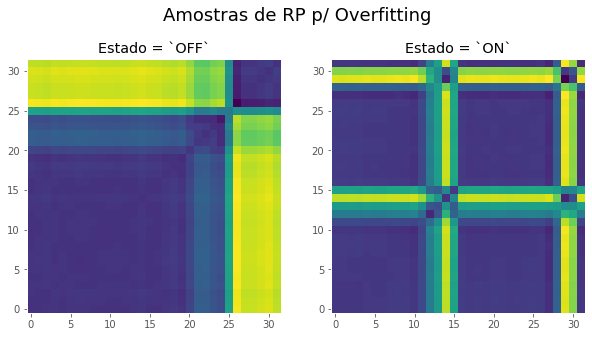

In [225]:
# IDEUA: Selecionar N amostras de classes distintas e verificar se modelo
#  consegue aprender (ou seja, sobreajustar) em poucas iterações.

from sklearn.utils import shuffle

# Selecionando N amostras 'aleatoriamente' de cada classe
num_amostras = 2
np.random.seed(SEED)
idx = np.random.choice(
    [y[0] for y in np.argwhere(y_treino == 1)], num_amostras, replace=False
)
X_positivo, y_positivo = X_treino_imagem[idx], y_treino[idx]

idx = np.random.choice(
    [y[0] for y in np.argwhere(y_treino == 0)], num_amostras, replace=False
)
X_negativo, y_negativo = X_treino_imagem[idx], y_treino[idx]

# Amostras para overfiting
X_amostra, y_amostra = shuffle(
    np.concatenate([X_positivo, X_negativo]),
    np.concatenate([y_positivo, y_negativo]),
    random_state=SEED
)
    
# X,y = [], []
# for i, amostra in enumerate(X_treino):
#     rotulo = y_treino[i]
#     # Verificar se N possui amostra da classe
#     if y.count(rotulo) == 0:
#         #imagem = serie_para_imagem(amostra)
#         X.append(amostra)
#         y.append(rotulo)
    
#     # Verificar se ja possui condicao de parada (1 de cada classe)
#     if np.unique(y).shape[0] == 2:
#         break
        
# Amostras selecionadas
fig, axes  = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(X_negativo[0][:,:,0], origin="lower")
axes[0].set_title(f"Estado = `{estados[0]}`")
axes[0].grid(False)
axes[1].imshow(X_positivo[0][:,:,0], origin="lower")
axes[1].set_title(f"Estado = `{estados[1]}`")
axes[1].grid(False)
plt.suptitle("Amostras de RP p/ Overfitting", size=18, y=1.0);


del idx
del X_positivo
del y_positivo
del X_negativo
del y_negativo

In [226]:
# Instanciando modelo
# modelo_overfitting = modelo_baseline(
#     optimizer=tf.keras.optimizers.RMSprop(1e-3, momentum=0.5),
#     bias_output=bias_inicial_output
# )
modelo_overfitting = convnet_h1(
    #input_shape= X_amostra[0].shape,
    dropout=0,
    optimizer=tf.keras.optimizers.RMSprop(1e-2),#Adam(1e-2, amsgrad=True),    
    loss_function='binary_crossentropy',
    metrics=['accuracy'],
)
print("* Detalhes do modelo:")
print("---")
print(modelo_overfitting.summary())
print()

* Detalhes do modelo:
---
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               590336    
_________________________________________________________________
dense_1 (Dense)              (

In [227]:
print("* Treinando:")
print("---")
historico = modelo_overfitting.fit(
    np.asarray(X_amostra).astype(TIPO_DADOS), np.array(y_amostra),
    #class_weight=pesos_classes,
    epochs=10,
    verbose=2    
)

* Treinando:
---
Epoch 1/10
1/1 - 0s - loss: 26.4025 - accuracy: 0.2500
Epoch 2/10
1/1 - 0s - loss: 508.7916 - accuracy: 0.5000
Epoch 3/10
1/1 - 0s - loss: 13415.3047 - accuracy: 0.5000
Epoch 4/10
1/1 - 0s - loss: 131.3851 - accuracy: 0.5000
Epoch 5/10
1/1 - 0s - loss: 413.2443 - accuracy: 0.7500
Epoch 6/10
1/1 - 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 7/10
1/1 - 0s - loss: 3.7669e-04 - accuracy: 1.0000
Epoch 8/10
1/1 - 0s - loss: 1.5618e-04 - accuracy: 1.0000
Epoch 9/10
1/1 - 0s - loss: 8.4217e-05 - accuracy: 1.0000
Epoch 10/10
1/1 - 0s - loss: 5.3255e-05 - accuracy: 1.0000


**NOTA:** A arquitetura de modelo em questão é capaz de aprender os padrões dos dados de diferentes classes em menos de 10 iterações.

#### Melhorando resultados - `Hipótese 1`: Entrada Normalizada + Bias Inicial da camada de Saída + Inicialização dos Kernels + EarlyStopping + Punição Desbalanceamento (Lote Aumentado)

In [232]:
# HIPOTESE - Centralizar por amostra

# Convertendo series para imagem
print("* Preparando dados...")
print("---")
X_treino_imagem, _ = preparar_amostras(
    X_treino,y_treino, 
    params_rp=CONFIG_RP_APARELHO,
    tam_imagem=TAMANHO_IMAGEM,
    centralizar=True 
)
X_teste_imagem, _ = preparar_amostras(
    X_teste,y_teste, 
    params_rp=CONFIG_RP_APARELHO,
    tam_imagem=TAMANHO_IMAGEM,
    centralizar=True 
)

# HIPOTESE - normalizando
desvio = X_treino_imagem.std()
X_treino_imagem /= desvio
X_teste_imagem /= desvio

print()

# Parada antecipada
metricas = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.AUC(name='auc'),
]
early_stopping_auc = tf.keras.callbacks.EarlyStopping(
    min_delta=1e-5,
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True
)
early_stopping_loss = tf.keras.callbacks.EarlyStopping(
    min_delta=1e-5,
    monitor='val_loss', 
    verbose=0,
    patience=10,
    mode='min',
    restore_best_weights=True
)

* Preparando dados...
---


In [233]:
# Avaliacao inicial
modelo = convnet_h1(
    dropout=0,
    optimizer=tf.keras.optimizers.RMSprop(1e-2),#Adam(1e-2, amsgrad=True),    
    loss_function='binary_crossentropy',
    metrics=metricas,
    bias_output=bias_inicial_output
)

resultado = modelo.evaluate(X_treino_imagem, y_treino, batch_size=TAMANHO_LOTE, verbose=0)
print("Loss: {:0.4f}".format(resultado[0]))
print("  -> Esperado:", round(erro_inicial_esperado, 4))

Loss: 0.0701
  -> Esperado: 0.6931


In [234]:
print("* Avaliando modelo NA BASE DE TREINO, aguarde...")
print("---")
y_true, y_pred = [], []
scores = []
aucs = []

# Avaliando N vezes o conjunto treino/teste (consitencia)
N = 1
for i in tqdm_notebook(range(N)):
    
    # Modelo Hipótese
    modelo = convnet_h1(
        dropout=0,
        optimizer=tf.keras.optimizers.Adam(1e-3),#, amsgrad=True),    
        metrics=metricas,
        bias_output=bias_inicial_output
    )
    # Treinando
    historico = modelo.fit(
        X_treino_imagem, y_treino,
        validation_data=(X_treino_imagem, y_treino),
        epochs=EPOCAS,
        batch_size=TAMANHO_LOTE**2,
        callbacks=[early_stopping],
        class_weight=pesos_classes,
        #verbose=VERBOSIDADE
        verbose=2
    )
    
    # Avaliando
    y_hat = modelo.predict(X_treino_imagem).round().astype(np.int16)
    
    tf.keras.backend.clear_session()
    
    # Incrementando resultados
    score = f1_score(y_treino, y_hat, average="macro")
    auc_score = roc_auc_score(y_treino, y_hat)
    print("   -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
        i+1, 
        score*100,
        auc_score,
    ))
    scores.append(score)
    aucs.append(auc_score)
    y_true.extend(y_treino)
    y_pred.extend(y_hat)
    
print()
print("* Resultados finais:")
print("---")
print()

print("   - F1-score (macro):")
print()
print("     . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
print("     . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
print("     . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
print("     . Máximo        : {:.2f}%".format(np.max(scores)*100) )
print()
print("   - AUC:")
print()
print("     . Média geral   : {:.3f}".format(np.mean(aucs) ) )
print("     . Desvio padrão : {:.3f}".format(np.std(aucs)) )
print("     . Mínimo        : {:.3f}".format(np.min(aucs)) )
print("     . Máximo        : {:.3f}".format(np.max(aucs)) )
print()

print("   - Relatório de classificação:")
print()
print(classification_report(y_true, y_pred))
print("   - Matrix de confusao:")
print()
print(confusion_matrix(y_true, y_pred))

* Avaliando modelo NA BASE DE TREINO, aguarde...
---


Epoch 1/100
4/4 - 1s - loss: 1.6278 - accuracy: 0.9655 - auc: 0.7262 - val_loss: 2.0460 - val_accuracy: 0.9287 - val_auc: 0.9012
Epoch 2/100
4/4 - 0s - loss: 1.3006 - accuracy: 0.9300 - auc: 0.9028 - val_loss: 0.5033 - val_accuracy: 0.9553 - val_auc: 0.9096
Epoch 3/100
4/4 - 1s - loss: 0.8039 - accuracy: 0.9689 - auc: 0.8879 - val_loss: 0.1571 - val_accuracy: 0.9721 - val_auc: 0.8907
Epoch 4/100
4/4 - 0s - loss: 0.7986 - accuracy: 0.9744 - auc: 0.8918 - val_loss: 0.4219 - val_accuracy: 0.9572 - val_auc: 0.9117
Epoch 5/100
4/4 - 0s - loss: 0.7706 - accuracy: 0.9546 - auc: 0.9128 - val_loss: 0.5829 - val_accuracy: 0.9517 - val_auc: 0.9117
Epoch 6/100
4/4 - 0s - loss: 0.7703 - accuracy: 0.9537 - auc: 0.9109 - val_loss: 0.3907 - val_accuracy: 0.9585 - val_auc: 0.9121
Epoch 7/100
4/4 - 0s - loss: 0.6993 - accuracy: 0.9621 - auc: 0.9115 - val_loss: 0.1576 - val_accuracy: 0.9741 - val_auc: 0.9165
Epoch 8/100
4/4 - 0s - loss: 0.7383 - accuracy: 0.9780 - auc: 0.9316 - val_loss: 0.1789 - val_acc

**NOTA:** a arquitetura proposta é capaz de aprender os padrões do lote de treino. Cabe ressaltar ainda a dificuldade de atingir o overfiting devido aos Falsos Negativos (desbalanceamento classe positiva).

In [237]:
TAMANHO_LOTE_AUMENTADO = 128

In [236]:
print("* Avaliando modelo NA BASE DE TESTE, aguarde...")
print("---")
y_true, y_pred = [], []
scores = []
aucs = []

# Avaliando N vezes o conjunto treino/teste (consitencia)
N = 5
for i in tqdm_notebook(range(N)):
    
    # Modelo Hipótese
    modelo = convnet_h1(
        dropout=0.1,
        optimizer=tf.keras.optimizers.Adam(1e-3),# amsgrad=True),
        loss_function='binary_crossentropy',        
        metrics=metricas,
        bias_output=bias_inicial_output
    )
    # Treinando
    historico = modelo.fit(
        X_treino_imagem, y_treino,
        validation_data=(X_teste_imagem, y_teste),
        epochs=EPOCAS,
        batch_size=TAMANHO_LOTE_AUMENTADO,
        class_weight=pesos_classes,
        callbacks=[early_stopping_auc],
        #verbose=VERBOSIDADE
        verbose=0
    )
    
    # Avaliando
    y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
    
    tf.keras.backend.clear_session()
    
    # Incrementando resultados
    score = f1_score(y_teste, y_hat, average="macro")
    auc_score = roc_auc_score(y_teste, y_hat)
    print("   -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
        i+1, 
        score*100,
        auc_score,
    ))
    scores.append(score)
    aucs.append(auc_score)
    y_true.extend(y_teste)
    y_pred.extend(y_hat)
    
print()
print("* Resultados finais:")
print("---")
print()

print("   - F1-score (macro):")
print()
print("     . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
print("     . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
print("     . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
print("     . Máximo        : {:.2f}%".format(np.max(scores)*100) )
print()
print("   - AUC:")
print()
print("     . Média geral   : {:.3f}".format(np.mean(aucs) ) )
print("     . Desvio padrão : {:.3f}".format(np.std(aucs)) )
print("     . Mínimo        : {:.3f}".format(np.min(aucs)) )
print("     . Máximo        : {:.3f}".format(np.max(aucs)) )
print()

print("   - Relatório de classificação:")
print()
print(classification_report(y_true, y_pred))
print("   - Matrix de confusao:")
print()
print(confusion_matrix(y_true, y_pred))

* Avaliando modelo NA BASE DE TESTE, aguarde...
---


   -> # TENTATIVA #1: F1-score = 64.79% / AUC = 0.805
   -> # TENTATIVA #2: F1-score = 60.66% / AUC = 0.840
   -> # TENTATIVA #3: F1-score = 69.81% / AUC = 0.897
   -> # TENTATIVA #4: F1-score = 74.55% / AUC = 0.901
   -> # TENTATIVA #5: F1-score = 66.82% / AUC = 0.894

* Resultados finais:
---

   - F1-score (macro):

     . Média geral   : 67.33%
     . Desvio padrão : 4.68%
     . Mínimo        : 60.66%
     . Máximo        : 74.55%

   - AUC:

     . Média geral   : 0.867
     . Desvio padrão : 0.038
     . Mínimo        : 0.805
     . Máximo        : 0.901

   - Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      5090
           1       0.22      0.76      0.35        55

    accuracy                           0.97      5145
   macro avg       0.61      0.87      0.66      5145
weighted avg       0.99      0.97      0.98      5145

   - Matrix de confusao:

[[4944  146]
 [  13   42]]


**NOTA:** Houve ganhos de ~15% f1 médio, além de menor desvio (~1%) nos resultados obtidos. Todavia, observa-se o alto índice de Falso Positivo (baixa Precisão para classe positiva).

#### `Hipótese 2`: Hipótese 1 + expansão canais

In [245]:
def expandir_canais(matriz, canais=3):
    return np.concatenate([matriz for _ in range(3)], axis=-1)

In [247]:
print("* Avaliando modelo, aguarde...")
print("---")
y_true, y_pred = [], []
scores = []
aucs = []

# Avaliando N vezes o conjunto treino/teste (consitencia)
N = 5
for i in tqdm_notebook(range(N)):
    
    # Modelo Hipótese
    modelo = convnet_h1(
        input_shape=(32,32,3),
        dropout=0.1,
        optimizer=tf.keras.optimizers.Adam(1e-3),# amsgrad=True),
        loss_function='binary_crossentropy',        
        metrics=metricas,
        bias_output=bias_inicial_output
    )
    # Treinando
    historico = modelo.fit(
        expandir_canais(X_treino_imagem), y_treino,
        validation_data=(expandir_canais(X_teste_imagem), y_teste),
        epochs=EPOCAS,
        batch_size=TAMANHO_LOTE_AUMENTADO,
        class_weight=pesos_classes,
        callbacks=[early_stopping_auc],
        #verbose=VERBOSIDADE
        verbose=0
    )
    
    # Avaliando
    y_hat = modelo.predict(expandir_canais(X_teste_imagem)).round().astype(np.int16)
    
    tf.keras.backend.clear_session()
    
    # Incrementando resultados
    score = f1_score(y_teste, y_hat, average="macro")
    auc_score = roc_auc_score(y_teste, y_hat)
    print("   -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
        i+1, 
        score*100,
        auc_score,
    ))
    scores.append(score)
    aucs.append(auc_score)
    y_true.extend(y_teste)
    y_pred.extend(y_hat)
    
print()
print("* Resultados finais:")
print("---")
print()

print("   - F1-score (macro):")
print()
print("     . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
print("     . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
print("     . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
print("     . Máximo        : {:.2f}%".format(np.max(scores)*100) )
print()
print("   - AUC:")
print()
print("     . Média geral   : {:.3f}".format(np.mean(aucs) ) )
print("     . Desvio padrão : {:.3f}".format(np.std(aucs)) )
print("     . Mínimo        : {:.3f}".format(np.min(aucs)) )
print("     . Máximo        : {:.3f}".format(np.max(aucs)) )
print()

print("   - Relatório de classificação:")
print()
print(classification_report(y_true, y_pred))
print("   - Matrix de confusao:")
print()
print(confusion_matrix(y_true, y_pred))

* Avaliando modelo, aguarde...
---


   -> # TENTATIVA #1: F1-score = 74.55% / AUC = 0.901
   -> # TENTATIVA #2: F1-score = 66.86% / AUC = 0.807
   -> # TENTATIVA #3: F1-score = 66.86% / AUC = 0.807
   -> # TENTATIVA #4: F1-score = 66.86% / AUC = 0.807
   -> # TENTATIVA #5: F1-score = 66.86% / AUC = 0.807

* Resultados finais:
---

   - F1-score (macro):

     . Média geral   : 68.40%
     . Desvio padrão : 3.08%
     . Mínimo        : 66.86%
     . Máximo        : 74.55%

   - AUC:

     . Média geral   : 0.826
     . Desvio padrão : 0.038
     . Mínimo        : 0.807
     . Máximo        : 0.901

   - Relatório de classificação:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5090
           1       0.26      0.67      0.38        55

    accuracy                           0.98      5145
   macro avg       0.63      0.83      0.68      5145
weighted avg       0.99      0.98      0.98      5145

   - Matrix de confusao:

[[4986  104]
 [  18   37]]


**NOTA:** Sem ganhos expandindo hipóteses.

#### `Hipótese 3`: Hipótese 1 + Aumento de Dados (Jack Kelly, 2015)

Para criar dados agregados sintéticos, começamos extraindo um conjunto de ativações de aparelhos para cinco aparelhos em todas as casas de treinamento: chaleira, máquina de lavar roupa, lava-louças, microondas e geladeira.

Para criar uma única sequência de dados sintéticos, começamos com dois vetores de zeros: um vetor se tornará a entrada da rede; o outro se tornará o alvo. O comprimento de cada vetor define a "largura da janela" dos dados que a rede vê.

Passamos pelas cinco classes de dispositivos e decidimos se deve ou não adicionar uma ativação dessa classe à sequência de treinamento. Há 50% de chance de o appliance de destino aparecer na sequência e 25% de chance para o appliance de 'distração'.

Para cada classe de dispositivo selecionada, selecionamos aleatoriamente uma ativação do dispositivo e escolhemos aleatoriamente onde adicionar essa ativação no vetor de entrada. Os dispositivos distratores podem aparecer em qualquer lugar da sequência (mesmo que isso signifique que apenas parte da ativação será incluída na sequência). A ativação do dispositivo-alvo deve estar completamente contida na sequência (a menos que seja grande demais para caber).

------------
**Referências:**
    - https://jack-kelly.com/files/writing/jack-kelly-phd-thesis.pdf
    - https://github.com/JackKelly/neuralnilm_prototype/blob/master/notebooks/synthetic_data_generator.ipynb

In [248]:
def obter_ativacoes(residencia, aparelhos):
    ativacoes = {}
    for aparelho in aparelhos:
        for m in residencia.elec.all_meters():
            if not hasattr(m, 'meters'):
                e_label = m.label().lower().replace(" ","_")
                if aparelho == e_label:
                    ativacoes[aparelho] = m.get_activations()[0].values
                    break
            else:
                m = m.meters[0]
                e_label = m.label().lower().replace(" ","_")
                if aparelho == e_label:
                    ativacoes[aparelho] = m.get_activations()[0].values
                    break
    return ativacoes

def gerar_ativacao_sintetica(
    ativacoes, aparelho_alvo=True, 
    tamanho_amostra=30, taxa_amostral=5,
    permitir_alvo_incompleto=False, permitir_distrator_incompleto=True
    
):    
    """
    Parameters
    ----------
    ativacoes : pd.Series
    aparelho_alvo : bool

    Returns
    -------
    pd.Series
    """
        
    serie_ativacoes = pd.Series(ativacoes)
    
    if aparelho_alvo:
        permitir_incompleto = permitir_alvo_incompleto
    else:
        permitir_incompleto = permitir_distrator_incompleto

    # Select a start index
    if permitir_incompleto:
        earliest_start_i = -len(ativacoes)
        latest_start_i = tamanho_amostra
    else:
        if len(ativacoes) > tamanho_amostra:
            raise RuntimeError("ativacoes muito longa para a amostra"
                               " e amostras incompletas não são permitidas.")
        earliest_start_i = 0
        latest_start_i = tamanho_amostra - len(ativacoes)

    start_i = np.random.randint(low=earliest_start_i, high=latest_start_i)

    # Clip or pad head of sequence
    if start_i < 0:
        nova_amostra = serie_ativacoes.values[-start_i:]
    else:
        nova_amostra = np.pad(
            serie_ativacoes.values, pad_width=(start_i, 0), mode='constant')

    # Clip or pad tail to produce a sequence which is tamanho_amostra long
    if len(nova_amostra) <= tamanho_amostra:
        n_zeros_to_pad = tamanho_amostra - len(nova_amostra)
        nova_amostra = np.pad(
            nova_amostra, pad_width=(0, n_zeros_to_pad),
            mode='constant')
    else:
        nova_amostra = nova_amostra[:tamanho_amostra]

    if len(ativacoes) > tamanho_amostra:
        amostra_cheia = False
    else:
        space_after_ativacoes = tamanho_amostra - len(ativacoes)
        amostra_cheia = 0 <= start_i <= space_after_ativacoes

    return nova_amostra#, amostra_cheia

# GERANDO NOVA AMOSTRA SINTÉTICA
def gerar_amostra_sintetica(**kwargs):
    
    residencia = kwargs.get('residencia')
    aparelhos = kwargs.get('aparelhos')
    aparelho_alvo = kwargs.get('aparelho_alvo')
    tamanho_amostra = kwargs.get('tamanho_amostra')
    probs = kwargs.get('probs')
    taxa_amostral = kwargs.get('taxa_amostral')
    debug = kwargs.get('debug')
    
    #1. Obter ativacoes
    ativacoes = obter_ativacoes(residencia, aparelhos)
    # print(ativacoes)

    #2. Gerar uma amostra coring
    nova_amostra = np.zeros(tamanho_amostra)
    rotulo = 0

    #3.
    # 3.1. probabilidade de inserir o aparelho principal
    if np.random.binomial(n=1, p=probs["alvo"]):
        amostra = gerar_ativacao_sintetica(
            ativacoes=ativacoes[aparelho_alvo], 
            tamanho_amostra=tamanho_amostra,
            taxa_amostral=taxa_amostral,    
            aparelho_alvo=True
        )
        nova_amostra += amostra
        rotulo = 1

        if debug: plt.plot(np.arange(len(amostra)), amostra, label=aparelho_alvo+"*");    

    # 3.2.  Probabilidade de incluir distratores
    distratores = list(set(aparelhos) - set([aparelho_alvo]))
    for aparelho in distratores:
        if np.random.binomial(n=1, p=probs["distrator"]):
            amostra = gerar_ativacao_sintetica(
                ativacoes=ativacoes[aparelho], 
                tamanho_amostra=tamanho_amostra,
                taxa_amostral=taxa_amostral,    
                aparelho_alvo=False
            )
            nova_amostra += amostra

            if debug: plt.plot(np.arange(len(amostra)), amostra, label=aparelho);   

    if debug: 
        plt.plot(np.arange(len(nova_amostra)), nova_amostra, label="amostra sintética");  
        plt.legend();
        plt.title(f"Nova amostra sintética (Classe = {rotulo})");
        plt.show()
    
    return nova_amostra, rotulo

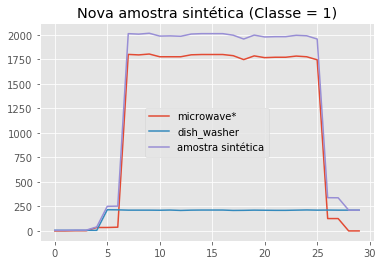

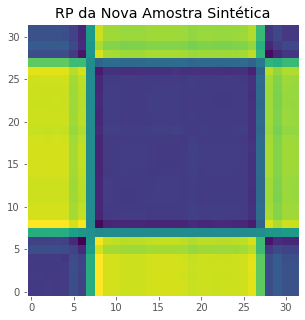

In [249]:
# Exemplo

# Gerando nova amostra
nova_amostra, rotulo = gerar_amostra_sintetica(**{
    "residencia": janelas.residencia,
    "aparelhos": ["fridge","dish_washer","washer_dryer","microwave"],
    "aparelho_alvo": "microwave",
    "tamanho_amostra": TAMANHO_JANELA,
    "probs": {"alvo": 0.75, "distrator": 0.25},
    "taxa_amostral": 5,
    "debug": True
})

# Convertendo para imagem (entrada do modelo)
fig = plt.figure(figsize=(5,5))
plt.imshow(serie_para_imagem(nova_amostra)[:,:,0], origin="lower")
plt.grid(False)
plt.title("RP da Nova Amostra Sintética")
plt.show()

In [ ]:
# Gerando amostras sinteticas (razao 50:50)
print("* Gerando reamostragem sintética do conjunto de treino...")
print("---")
total_amostras_sinteticas = int(X_treino.shape[0] * 1)

amostras_sinteticas = {"X": [], "y":[]}
for _ in tqdm_notebook(range(total_amostras_sinteticas)):

    # Gerando nova amostra
    nova_amostra, rotulo = gerar_amostra_sintetica(**{
        "residencia": janelas.residencia,
        "aparelhos": ["fridge","dish_washer","washer_dryer","microwave"],
        "aparelho_alvo": "microwave",
        "tamanho_amostra": TAMANHO_JANELA,
        "probs": {"alvo": 0.7, "distrator": 0.25},
        "taxa_amostral": TAXA,
        "debug": False
    })
    amostras_sinteticas["X"].append(nova_amostra)
    amostras_sinteticas["y"].append(rotulo)

    
# Atualizando massa de treino
X_treino_aug = np.concatenate([X_treino, amostras_sinteticas["X"]])
y_treino_aug = np.concatenate([y_treino, amostras_sinteticas["y"]])
del amostras_sinteticas

# Bias nova distribuicao
neg, pos = np.bincount(y_treino_aug)
total = neg + pos
bias_inicial_output = np.log([pos/neg])    
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
pesos_classes = {0: weight_for_0, 1: weight_for_1}
print(f"   - Nova distribuicao: OFF:{neg} / ON:{pos} (bias={bias_inicial_output})")
print()

# Convertendo em imagem
X_treino_aug, _ = preparar_amostras(
    X_treino_aug, y_treino_aug, 
    params_rp=CONFIG_RP_APARELHO,
    tam_imagem=TAMANHO_IMAGEM,
    centralizar=True 
)
#del X_treino_aug
# Novamente lote de teste, para reescalonar X em função do novo desvio
X_teste_imagem, _ = preparar_amostras( 
    X_teste,y_teste, 
    params_rp=CONFIG_RP_APARELHO,
    tam_imagem=TAMANHO_IMAGEM,
    centralizar=True 
)


# HIPOTESE - normalizando
desvio = X_treino_aug.std()
X_treino_aug /= desvio
X_teste_imagem /= desvio
print()

* Gerando reamostragem sintética do conjunto de treino...
---


In [435]:
print("* Avaliando modelo, aguarde...")
print("---")
y_true, y_pred = [], []
scores = []
aucs = []

# Avaliando N vezes o conjunto treino/teste (consitencia)
N = 5
for i in tqdm_notebook(range(N)):
    
    # Modelo Hipótese
    modelo = convnet_h1(
        dropout=0.1,
        optimizer=tf.keras.optimizers.Adam(1e-3),# amsgrad=True),
        loss_function='binary_crossentropy',        
        metrics=metricas,
        bias_output=bias_inicial_output
    )
    # Treinando
    historico = modelo.fit(
        X_treino_aug, y_treino_aug,
        validation_data=(X_teste_imagem, y_teste),
        epochs=EPOCAS,
        batch_size=TAMANHO_LOTE_AUMENTADO,
        class_weight=pesos_classes,
        callbacks=[early_stopping_auc],
        #verbose=VERBOSIDADE
        verbose=0
    )
    
    # Avaliando
    y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
    
    tf.keras.backend.clear_session()
    
    # Incrementando resultados
    score = f1_score(y_teste, y_hat, average="macro")
    auc_score = roc_auc_score(y_teste, y_hat)
    print("   -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
        i+1, 
        score*100,
        auc_score,
    ))
    scores.append(score)
    aucs.append(auc_score)
    y_true.extend(y_teste)
    y_pred.extend(y_hat)
    
print()
print("* Resultados finais:")
print("---")
print()

print("   - F1-score (macro):")
print()
print("     . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
print("     . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
print("     . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
print("     . Máximo        : {:.2f}%".format(np.max(scores)*100) )
print()
print("   - AUC:")
print()
print("     . Média geral   : {:.3f}".format(np.mean(aucs) ) )
print("     . Desvio padrão : {:.3f}".format(np.std(aucs)) )
print("     . Mínimo        : {:.3f}".format(np.min(aucs)) )
print("     . Máximo        : {:.3f}".format(np.max(aucs)) )
print()

print("   - Relatório de classificação:")
print()
print(classification_report(y_true, y_pred))
print("   - Matrix de confusao:")
print()
print(confusion_matrix(y_true, y_pred))

* Avaliando modelo, aguarde...
---


   -> # TENTATIVA #1: F1-score = 61.45% / AUC = 0.589
   -> # TENTATIVA #2: F1-score = 60.77% / AUC = 0.588
   -> # TENTATIVA #3: F1-score = 60.77% / AUC = 0.588
   -> # TENTATIVA #4: F1-score = 60.77% / AUC = 0.588
   -> # TENTATIVA #5: F1-score = 61.45% / AUC = 0.589

* Resultados finais:
---

   - F1-score (macro):

     . Média geral   : 61.04%
     . Desvio padrão : 0.33%
     . Mínimo        : 60.77%
     . Máximo        : 61.45%

   - AUC:

     . Média geral   : 0.589
     . Desvio padrão : 0.000
     . Mínimo        : 0.588
     . Máximo        : 0.589

   - Relatório de classificação:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5090
           1       0.30      0.18      0.23        55

    accuracy                           0.99      5145
   macro avg       0.65      0.59      0.61      5145
weighted avg       0.98      0.99      0.99      5145

   - Matrix de confusao:

[[5067   23]
 [  45   10]]


In [ ]:
del X_treino_aug
del y_treino_aug

**NOTA:**: Não houve ganho, pelo contrário, as novas imagens acabaram acrescentando ruído e mitigando a generalização do modelo.

#### `Hipótese 4`: Hipótese 1 + Aumento de Dados (Janelas Positivas de Outras Residências)

In [628]:
def carregar_dicionario_reamostragem(residencias_reamostragem, dataset = redd):
    dados_reamostragem = {i: None for i in residencias_reamostragem}

    # Carregando os registros de cada residencia (bag of windows)
    print("* Carregando dados das residencias de reamostragem...")
    for r in tqdm_notebook(residencias_reamostragem):

        # Carregar dados
        janelas = Janelas(**{
            "base":dataset,
            "id_residencia":r,
            "inicio_intervalo":'2011-04-16 05:11:30',
            "fim_intervalo":'2011-04-23 08:43:26',
            "debug": False    
        })

        # Extrair series divididas em janelas para cada medidor
        dados_cargas = janelas.preparar(
            taxa_amostral=TAXA, 
            intervalo_medicao=TAMANHO_JANELA
        )
        print()

        # Pprearando dados (Serie / Estado)
        # X
        dados_medidores = janelas.filtrar_cargas(
            dados_cargas,
            filtros=[
                (1, 'site_meter'),
                (2, 'site_meter'),    
            ]
        )
        amostras = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]

        # y
        # LOCALIZANDO O ID DO APARELHO NA RESIDENCIA
        instancia_carga = None
        for e in janelas.residencia.elec.meters:
            if not hasattr(e, 'meter'):
                label = e.label().lower().replace(" ","_")
                if CARGA == label:
                    instancia_carga = e.instance()
            else:
                for em in e.meters:
                    label = em.label().lower().replace(" ","_")
                    if CARGA == label:
                        instancia_carga = e.instance()
        
        if instancia_carga is None:
            print("# ATENÇÃO: Não foi possível localizar o aparelho na residencia!")
        dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(instancia_carga, CARGA)])[0]
        rotulos = dados_aparelho["rotulos"]["estado"]

        dados_reamostragem[r] = {"X": amostras, "y": rotulos}

        # <<< Limpando memoria >>>
        dados_cargas = None
        del dados_cargas
        dados_medidores = None
        del dados_medidores
        dados_aparelho = None
        del dados_aparelho
        del amostras
        del rotulos
        gc.collect()
        # <<< Limpando memoria >>>
        
    return dados_reamostragem

def gerar_amostra_vizinho(
    dados_reamostragem, apenas_positiva = True,
    proba_positiva = 0.75 # Usada apenas quando apenas_positiva = False
):

    # Escolhendo uma residencia
    residencias_reamostragem = list(dados_reamostragem.keys())                            
    residencia_escolhida = np.random.choice(residencias_reamostragem, 1)[0]

    # Carregando dados da residencia
    dados_residencia = dados_reamostragem[residencia_escolhida]

    # Checar de qual classe sera a nova amostra
    if apenas_positiva == True:
        classe_nova_amostra = 1
    else:
        # Deixar probabilisticamente deficinr classe de amostra
        positiva = np.random.binomial(1, 0.5)
        if positiva == 1:
            classe_nova_amostra = 1
        else:
            classe_nova_amostra = 0

    # Classe amostra
    indices_sorteio = np.argwhere(dados_residencia["y"] == classe_nova_amostra).transpose()[0]

    # Sorteio do indice da nova amostra
    idx_nova_amostra = np.random.choice(indices_sorteio, 1)[0]

    
    return (
        dados_residencia["X"][idx_nova_amostra],
        dados_residencia["y"][idx_nova_amostra], 
        {
            "residencia": residencia_escolhida,
            "indice": idx_nova_amostra
        }
    )

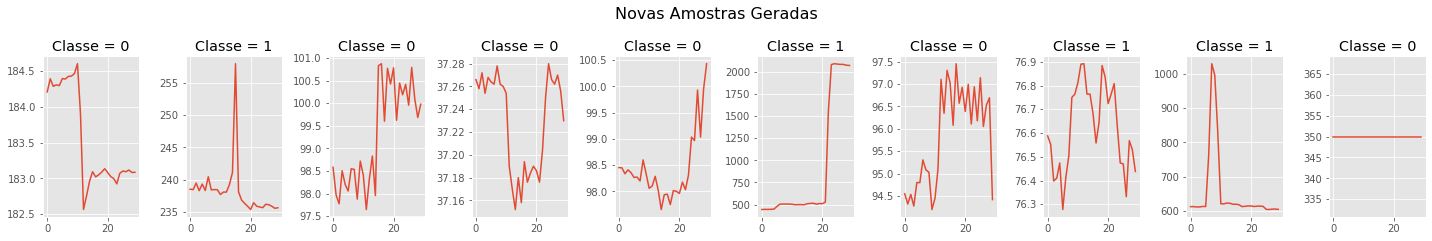

In [629]:
# EXEMPLO...
n = 10
fig, axes = plt.subplots(1, n, figsize=(20,3))
for i in range(n):
    nova_amostra, rotulo, _ = gerar_amostra_vizinho(
        dados_reamostragem=dados_reamostragem,
        apenas_positiva=False,
        proba_positiva=0.95
    )
    axes[i].plot(np.arange(len(nova_amostra)), nova_amostra)
    axes[i].set_title(f"Classe = {rotulo}");

plt.suptitle("Novas Amostras Geradas", size=16, y=1.1)
plt.tight_layout()
plt.show()

In [ ]:
# Convertendo series para imagem
print("* Preparando dados...")
print("---")
X_treino_imagem, _ = preparar_amostras(
    X_treino,y_treino, 
    params_rp=CONFIG_RP_APARELHO,
    tam_imagem=TAMANHO_IMAGEM,
    centralizar=True 
)
X_teste_imagem, _ = preparar_amostras(
    X_teste,y_teste, 
    params_rp=CONFIG_RP_APARELHO,
    tam_imagem=TAMANHO_IMAGEM,
    centralizar=True 
)

# HIPOTESE - normalizando
desvio = X_treino_imagem.std()
X_treino_imagem /= desvio
X_teste_imagem /= desvio

In [646]:
# Gerando amostras sinteticas (razao 50:50)
print("* Gerando reamostragem sintética do conjunto de treino...")
print("---")

dados_reamostragem = carregar_dicionario_reamostragem(
    residencias_reamostragem=[1,2,5],
    dataset=redd
)

neg, pos = np.bincount(y_treino)
total_amostras_sinteticas = neg - pos

amostras_sinteticas = {"X": [], "y":[]}
for _ in tqdm_notebook(range(total_amostras_sinteticas)):

    # Gerando nova amostra
    nova_amostra, rotulo, _ = gerar_amostra_vizinho(
        dados_reamostragem=dados_reamostragem,
        apenas_positiva=True
    )
    amostras_sinteticas["X"].append(nova_amostra)
    amostras_sinteticas["y"].append(rotulo)

# Atualizando massa de treino
X_treino_aug = np.concatenate([X_treino, amostras_sinteticas["X"]])
y_treino_aug = np.concatenate([y_treino, amostras_sinteticas["y"]])
del amostras_sinteticas

# Bias nova distribuicao
neg, pos = np.bincount(y_treino_aug)
total = neg + pos
bias_inicial_output = np.log([pos/neg])    
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
pesos_classes = {0: weight_for_0, 1: weight_for_1}
print(f"   - Nova distribuicao: OFF:{neg} / ON:{pos} (bias={bias_inicial_output})")
print()

# Convertendo em imagem
X_treino_aug, _ = preparar_amostras(
    X_treino_aug, y_treino_aug, 
    params_rp=CONFIG_RP_APARELHO,
    tam_imagem=TAMANHO_IMAGEM,
    centralizar=True 
)
#del X_treino_aug
# Novamente lote de teste, para reescalonar X em função do novo desvio
X_teste_imagem, _ = preparar_amostras( 
    X_teste,y_teste, 
    params_rp=CONFIG_RP_APARELHO,
    tam_imagem=TAMANHO_IMAGEM,
    centralizar=True 
)

# HIPOTESE - normalizando
desvio = X_treino_aug.std()
X_treino_aug /= desvio
X_teste_imagem /= desvio
print()

* Gerando reamostragem sintética do conjunto de treino...
---
* Carregando dados das residencias de reamostragem...


Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.


Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.



   - Nova distribuicao: OFF:3053 / ON:3053 (bias=[0.])



In [655]:
print("* Avaliando modelo, aguarde...")
print("---")
y_true, y_pred = [], []
scores = []
aucs = []

# Avaliando N vezes o conjunto treino/teste (consitencia)
N = 5
for i in tqdm_notebook(range(N)):
    
    # Modelo Hipótese
    modelo = convnet_h1(
        dropout=0.1,
        optimizer=tf.keras.optimizers.Adam(1e-3),# amsgrad=True),
        loss_function='binary_crossentropy',        
        metrics=metricas,
        bias_output=bias_inicial_output
    )
    # Treinando
    historico = modelo.fit(
        X_treino_aug, y_treino_aug,
        validation_data=(X_teste_imagem, y_teste),
        epochs=EPOCAS,
        batch_size=TAMANHO_LOTE_AUMENTADO,
        class_weight=pesos_classes,
        callbacks=[early_stopping_auc],
        #verbose=VERBOSIDADE
        verbose=0
    )
    
    # Avaliando
    y_hat = modelo.predict(X_teste_imagem).round().astype(np.int16)
    
    tf.keras.backend.clear_session()
    
    # Incrementando resultados
    score = f1_score(y_teste, y_hat, average="macro")
    auc_score = roc_auc_score(y_teste, y_hat)
    print("   -> # TENTATIVA #{}: F1-score = {:.2f}% / AUC = {:.3f}".format(
        i+1, 
        score*100,
        auc_score,
    ))
    scores.append(score)
    aucs.append(auc_score)
    y_true.extend(y_teste)
    y_pred.extend(y_hat)
    
print()
print("* Resultados finais:")
print("---")
print()

print("   - F1-score (macro):")
print()
print("     . Média geral   : {:.2f}%".format(np.mean(scores)*100 ) )
print("     . Desvio padrão : {:.2f}%".format(np.std(scores)*100) )
print("     . Mínimo        : {:.2f}%".format(np.min(scores)*100) )
print("     . Máximo        : {:.2f}%".format(np.max(scores)*100) )
print()
print("   - AUC:")
print()
print("     . Média geral   : {:.3f}".format(np.mean(aucs) ) )
print("     . Desvio padrão : {:.3f}".format(np.std(aucs)) )
print("     . Mínimo        : {:.3f}".format(np.min(aucs)) )
print("     . Máximo        : {:.3f}".format(np.max(aucs)) )
print()

print("   - Relatório de classificação:")
print()
print(classification_report(y_true, y_pred))
print("   - Matrix de confusao:")
print()
print(confusion_matrix(y_true, y_pred))

* Avaliando modelo, aguarde...
---


Epoch 1/100
191/191 - 2s - loss: 0.6806 - accuracy: 0.5658 - val_loss: 0.7780 - val_accuracy: 0.7677
Epoch 2/100
191/191 - 1s - loss: 0.6562 - accuracy: 0.6004 - val_loss: 0.7333 - val_accuracy: 0.8192
Epoch 3/100
191/191 - 1s - loss: 0.6500 - accuracy: 0.6040 - val_loss: 0.6979 - val_accuracy: 0.8727
Epoch 4/100
191/191 - 1s - loss: 0.6458 - accuracy: 0.6110 - val_loss: 0.7060 - val_accuracy: 0.8630
Epoch 5/100
191/191 - 1s - loss: 0.6403 - accuracy: 0.6141 - val_loss: 0.6995 - val_accuracy: 0.8795
Epoch 6/100
191/191 - 2s - loss: 0.6383 - accuracy: 0.6205 - val_loss: 0.6744 - val_accuracy: 0.9174
Epoch 7/100
191/191 - 2s - loss: 0.6358 - accuracy: 0.6228 - val_loss: 0.6837 - val_accuracy: 0.9067
Epoch 8/100
191/191 - 1s - loss: 0.6325 - accuracy: 0.6277 - val_loss: 0.6976 - val_accuracy: 0.8882
Epoch 9/100
191/191 - 1s - loss: 0.6324 - accuracy: 0.6318 - val_loss: 0.6946 - val_accuracy: 0.8950
Epoch 10/100
191/191 - 1s - loss: 0.6302 - accuracy: 0.6323 - val_loss: 0.6799 - val_accura

Epoch 82/100
191/191 - 1s - loss: 0.5816 - accuracy: 0.6569 - val_loss: 0.5708 - val_accuracy: 0.9689
Epoch 83/100
191/191 - 1s - loss: 0.5827 - accuracy: 0.6561 - val_loss: 0.5833 - val_accuracy: 0.9718
Epoch 84/100
191/191 - 1s - loss: 0.5814 - accuracy: 0.6567 - val_loss: 0.5745 - val_accuracy: 0.9699
Epoch 85/100
191/191 - 1s - loss: 0.5792 - accuracy: 0.6554 - val_loss: 0.6067 - val_accuracy: 0.9621
Epoch 86/100
191/191 - 1s - loss: 0.5811 - accuracy: 0.6569 - val_loss: 0.5922 - val_accuracy: 0.9660
Epoch 87/100
191/191 - 1s - loss: 0.5805 - accuracy: 0.6571 - val_loss: 0.5810 - val_accuracy: 0.9670
Epoch 88/100
191/191 - 1s - loss: 0.5791 - accuracy: 0.6557 - val_loss: 0.6120 - val_accuracy: 0.9621
Epoch 89/100
191/191 - 1s - loss: 0.5790 - accuracy: 0.6557 - val_loss: 0.5984 - val_accuracy: 0.9640
Epoch 90/100
191/191 - 1s - loss: 0.5787 - accuracy: 0.6566 - val_loss: 0.6284 - val_accuracy: 0.9592
Epoch 91/100
191/191 - 2s - loss: 0.5791 - accuracy: 0.6567 - val_loss: 0.5881 - v

#### `Hipótese 5:` Image Embedding + Oversampling

In [813]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(20, 20, 20), random_state=SEED)
clf.fit(X_treino_imagem.reshape(-1, np.product(TAMANHO_IMAGEM)), y_treino)

y_hat = clf.predict(X_teste_imagem.reshape(-1, np.product(TAMANHO_IMAGEM)))
print(classification_report(y_teste, y_hat))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1018
           1       0.00      0.00      0.00        11

    accuracy                           0.99      1029
   macro avg       0.49      0.50      0.50      1029
weighted avg       0.98      0.99      0.98      1029



reduced shape: (3087, 17)
recovered shape: (3087, 1024)


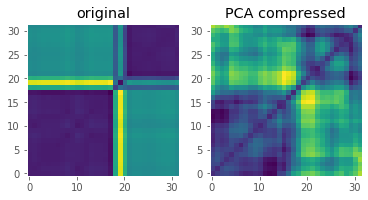

In [818]:
pca_dims = PCA()
pca_dims.fit(X_treino_imagem.reshape(-1, np.product(TAMANHO_IMAGEM)))
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_treino_imagem.reshape(-1, np.product(TAMANHO_IMAGEM)))
X_recovered = pca.inverse_transform(X_reduced)
print("reduced shape: " + str(X_reduced.shape))
print("recovered shape: " + str(X_recovered.shape))

f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(X_treino_imagem[0,:,:,0], origin="lower")
plt.grid(False)
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_recovered[0].reshape((32,32)), origin="lower")
plt.grid(False)
plt.show(block=True)

In [913]:
from sklearn.svm import SVC
clf_reduced = MLPClassifier(
    hidden_layer_sizes=(20, 20, 20), 
    solver='adam', alpha=1e-3, 
    batch_size=200,
    
    random_state=SEED
)
clf_reduced.fit(X_reduced, y_treino)

X_test_reduced = pca.transform(X_teste_imagem.reshape(-1, np.product(TAMANHO_IMAGEM)))
y_hat = clf_reduced.predict(X_test_reduced)
print(classification_report(y_teste, y_hat))
print(confusion_matrix(y_teste, y_hat))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1018
           1       0.33      0.36      0.35        11

    accuracy                           0.99      1029
   macro avg       0.66      0.68      0.67      1029
weighted avg       0.99      0.99      0.99      1029

[[1010    8]
 [   7    4]]


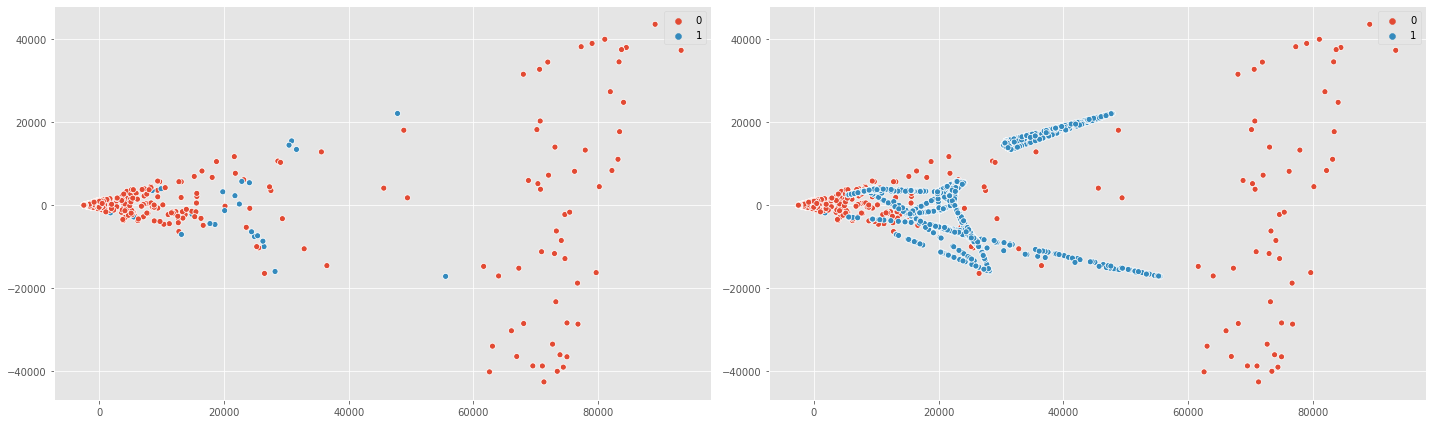

In [962]:
fig,axes = plt.subplots(1,2, figsize=(20,6))

sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=y_treino, ax=axes[0])

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, SVMSMOTE, SMOTENC, KMeansSMOTE
X_over,y_over = SVMSMOTE(random_state=SEED, n_jobs=5, sampling_strategy=0.9, k_neighbors=3).fit_resample(X_reduced, y_treino)
sns.scatterplot(x=X_over[:,0], y=X_over[:,1], hue=y_over, ax=axes[1] )

plt.tight_layout()

In [975]:
clf_reduced = MLPClassifier(
    hidden_layer_sizes=(20, 20, 20), 
    solver='adam', alpha=1e-3, 
    #batch_size=200,
    max_iter=1000,
    
    random_state=SEED
)
clf_reduced.fit(X_over, y_over)

#X_test_reduced = pca.transform(X_teste_imagem.reshape(-1, np.product(TAMANHO_IMAGEM)))

y_hat = clf_reduced.predict(X_test_reduced)
print(classification_report(y_teste, y_hat))
print(confusion_matrix(y_teste, y_hat))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1018
           1       0.30      0.27      0.29        11

    accuracy                           0.99      1029
   macro avg       0.65      0.63      0.64      1029
weighted avg       0.98      0.99      0.99      1029

[[1011    7]
 [   8    3]]


In [1043]:
clf_reduced = SVC(random_state=SEED, C=0.001)
clf_reduced.fit(X_over, y_over)

y_hat = clf_reduced.predict(X_test_reduced)

print(classification_report(y_teste, y_hat))
print(confusion_matrix(y_teste, y_hat))
print()
print("F1-macro:", round(f1_score(y_teste, y_hat, average="macro"),4))
print("AUC:", round(roc_auc_score(y_teste, y_hat),4))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1018
           1       0.26      0.82      0.39        11

    accuracy                           0.97      1029
   macro avg       0.63      0.90      0.69      1029
weighted avg       0.99      0.97      0.98      1029

[[992  26]
 [  2   9]]

F1-macro: 0.6887
AUC: 0.8963


In [1060]:
from xgboost.sklearn import XGBClassifier

# max_score = 0.8178
# max_param = 1
# for p in range(50):
#     xgb = XGBClassifier(eta=0.3, gamma=0, max_depth=6, min_child_weight=p,
#         learning_rate=1e-4, booster='gbtree', importance_type='gain',
#                         n_jobs=5, random_state=SEED)
#     xgb.fit(X_over, y_over)

#     y_hat = xgb.predict(X_test_reduced)
#     score = round(f1_score(y_teste, y_hat, average="macro"),4)
#     if score > max_score:
#         max_score = score
#         max_param = p
#         print("P = {} |- Score = {}".format(p, score))

# Avaliacao final
xgb = XGBClassifier(eta=0.3, gamma=0, max_depth=6, min_child_weight=24, reg_alpha=1,
                    #subsample=0.25, sampling_method='gradient_based', tree_method='gpu_hist',
    learning_rate=1e-4, booster='gbtree', importance_type='gain',
                    n_jobs=5, random_state=SEED)
xgb.fit(X_over, y_over)

y_hat = xgb.predict(X_test_reduced)

print(classification_report(y_teste, y_hat))
print(confusion_matrix(y_teste, y_hat))
print()
print("F1-macro:", round(f1_score(y_teste, y_hat, average="macro"),4))
print("AUC:", round(roc_auc_score(y_teste, y_hat),4))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1018
           1       0.57      0.73      0.64        11

    accuracy                           0.99      1029
   macro avg       0.78      0.86      0.82      1029
weighted avg       0.99      0.99      0.99      1029

[[1012    6]
 [   3    8]]

F1-macro: 0.8178
AUC: 0.8607


# Avaliação da Arquitetura para demais Aparelhos

In [106]:
# Intervalo de tempo e residencia considerados na base REDD
janelas = Janelas(**PARAMETROS_DATASET)
modelos = []
# 1) Para cada aparelho dos considerados no paper IEE GM
for i, r in df_melhores_janelas.loc[
    (df_melhores_janelas["carga"].isin([
                "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"
            ])), :
].iterrows():
    
    # Informacoes da carga (nome, id, taxa e janela)
    carga = r["carga"].split(" - ")[0]
    instancia = int(r["carga"].split(" - ")[1])
    taxa = r["taxa_amostragem"]
    janela = r["janela"]
    print(f"##### `{r['carga'].upper()}` / taxa={taxa} e janela={janela} / benchmarking --> f1={r['f1_macro']}...")
    print()
    
    # Pré-processamento das entradas
    print("* Preparando dados (treino/teste)...")
    print("---")

    # Constantes referente aos dados da carga selecionada
    TAXA = taxa
    TAMANHO_JANELA = janela

    # Extrair series divididas em janelas para cada medidor
    dados_cargas = janelas.preparar(
        taxa_amostral=TAXA, 
        intervalo_medicao=TAMANHO_JANELA
    )
    print()

    # Entrada
    dados_medidores = janelas.filtrar_cargas(
        dados_cargas,
        filtros=[
            (1, 'site_meter'),
            (2, 'site_meter'),    
        ]
    )
    X = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]
    X_imagem = RecurrencePlot().set_params(**PARAMETROS_RP).fit_transform(X)
    X_imagem = np.stack([
        [cv2.resize(
            imagem, 
            dsize=TAMANHO_IMAGEM, 
            interpolation=cv2.INTER_CUBIC).astype(np.float16) \
            for imagem in tqdm_notebook(X_imagem)]
    ], axis=-1).astype(np.float16) 

    # rotulos
    dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(instancia, carga)])[0]
    y = dados_aparelho["rotulos"]["estado"]

    # Fazendo split dos dados (treino/teste)
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X_imagem, y,
        test_size=FRACAO_TESTE,
        stratify=y if np.unique(y).shape[0] > 1 else None, # Ver viabilidade estratificacao
        random_state=SEED
    )

    # # Convertendo series em imagens
    # X_treino_imagens = np.stack([serie_para_imagem(x,params_rp=PARAMETROS_RP) for x in X_treino])
    # X_teste_imagens = np.stack([serie_para_imagem(x,params_rp=PARAMETROS_RP) for x in X_teste])
    print()

    print("* Carregando parametros da arquitetura...")
    print("---")

    # Inicializacao do output em compasso com distribuicao dos dados
    distribuicao_treino = Counter(y_treino)
    classe_minoritaria = min(distribuicao_treino, key=distribuicao_treino.get)
    classe_majoritaria = max(distribuicao_treino, key=distribuicao_treino.get)
    razao_min_maj  = np.float16(distribuicao_treino[classe_majoritaria]/distribuicao_treino[classe_minoritaria])
    bias_inicial_output = np.log([distribuicao_treino[1]/distribuicao_treino[0]])
    print("   -> Distribuição treino:", distribuicao_treino)
    print("      --- Classe minoritária :", classe_minoritaria)
    print("      --- Classe majoritaria :", classe_majoritaria)
    print("      --- Razão entre min/maj = {}:{}".format(1, razao_min_maj))
    print("      --- Bias inicial output =", bias_inicial_output)
    print()


    # calculando punicao para classes (desbalanceamento)
    dist_treino = [y for y in y_treino]
    pesos_classes = class_weight.compute_class_weight('balanced',np.unique(dist_treino),dist_treino)
    pesos_classes = {0: pesos_classes[0], 1: pesos_classes[1]}
    print("   -> Punição de classes:", pesos_classes)
    print()

    print("* Treinando modelo:")
    print("---")

    # Instanciando o modelo
    # modelo = modelo_baseline(
    #     optimizer=tf.keras.optimizers.Adam(1e-5),#RMSprop(1e-7, momentum=0.5),#,#
    #     #optimizer=tf.keras.optimizers.RMSprop(lr=1e-2, decay=0.01),
    #     loss=tf.keras.losses.BinaryCrossentropy(),
    #     #loss=binary_focal_loss(),
    #     bias_output=bias_inicial_output
    # )
    # #print(modelo.summary())
    modelo = convnet(bias_output=bias_inicial_output)

    historico = modelo.fit(
        x=X_treino, y=y_treino,
        validation_data=(X_teste, y_teste),
        batch_size=TAMANHO_LOTE,
        #class_weight=pesos_classes,
        epochs=EPOCAS,
        callbacks=[
            #tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=20)
        ],
        verbose=2    
    )
    print()

    print("* Avaliando modelo/hipótese no conjunto de teste...")
    print("---")
    y_pred = modelo.predict(X_teste).round().astype(np.int16)
    print()
    print(classification_report(y_teste, y_pred))#, labels=("OFF", "ON")))
    print(confusion_matrix(y_teste, y_pred))#, labels=("OFF", "ON")))

    tf.keras.backend.clear_session()
    
    modelos.append({r["carga"]: modelo})
          
    print()
    print("-"*80)
    print()

##### `FRIDGE - 7` / taxa=5 e janela=360 / benchmarking --> f1=100.0...

* Preparando dados (treino/teste)...
---
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.




* Carregando parametros da arquitetura...
---
   -> Distribuição treino: Counter({1: 199, 0: 58})
      --- Classe minoritária : 0
      --- Classe majoritaria : 1
      --- Razão entre min/maj = 1:3.431640625
      --- Bias inicial output = [1.23286181]

   -> Punição de classes: {0: 2.2155172413793105, 1: 0.6457286432160804}

* Treinando modelo:
---
Epoch 1/100
9/9 - 0s - loss: 1.7240 - accuracy: 0.7510 - val_loss: 0.3985 - val_accuracy: 0.7791
Epoch 2/100
9/9 - 0s - loss: 4.0764 - accuracy: 0.7743 - val_loss: 0.3510 - val_accuracy: 0.7791
Epoch 3/100
9/9 - 0s - loss: 1.5119 - accuracy: 0.7704 - val_loss: 0.3124 - val_accuracy: 0.7791
Epoch 4/100
9/9 - 0s - loss: 1.4433 - accuracy: 0.7510 - val_loss: 0.3085 - val_accuracy: 0.7791
Epoch 5/100
9/9 - 0s - loss: 1.4135 - accuracy: 0.7743 - val_loss: 0.2845 - val_accuracy: 0.7791
Epoch 6/100
9/9 - 0s - loss: 1.5870 - accuracy: 0.7549 - val_loss: 0.2492 - val_accuracy: 0.7791
Epoch 7/100
9/9 - 0s - loss: 0.3295 - accuracy: 0.7782 - val_lo

Epoch 81/100
9/9 - 0s - loss: 0.0077 - accuracy: 0.9961 - val_loss: 7.4701e-04 - val_accuracy: 1.0000
Epoch 82/100
9/9 - 0s - loss: 0.0050 - accuracy: 0.9961 - val_loss: 8.1676e-04 - val_accuracy: 1.0000
Epoch 83/100
9/9 - 0s - loss: 0.0047 - accuracy: 0.9961 - val_loss: 8.8713e-04 - val_accuracy: 1.0000
Epoch 84/100
9/9 - 0s - loss: 0.0077 - accuracy: 0.9961 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 85/100
9/9 - 0s - loss: 0.0048 - accuracy: 0.9961 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 86/100
9/9 - 0s - loss: 0.0057 - accuracy: 0.9961 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 87/100
9/9 - 0s - loss: 0.0034 - accuracy: 0.9961 - val_loss: 0.0148 - val_accuracy: 0.9884
Epoch 88/100
9/9 - 0s - loss: 0.0225 - accuracy: 0.9922 - val_loss: 0.0665 - val_accuracy: 0.9884
Epoch 89/100
9/9 - 0s - loss: 0.0034 - accuracy: 0.9961 - val_loss: 0.0819 - val_accuracy: 0.9884
Epoch 90/100
9/9 - 0s - loss: 0.1050 - accuracy: 0.9961 - val_loss: 0.0457 - val_accuracy: 0.9884
Epoch 91


* Carregando parametros da arquitetura...
---
   -> Distribuição treino: Counter({0: 1523, 1: 20})
      --- Classe minoritária : 1
      --- Classe majoritaria : 0
      --- Razão entre min/maj = 1:76.125
      --- Bias inicial output = [-4.33270508]

   -> Punição de classes: {0: 0.5065659881812212, 1: 38.575}

* Treinando modelo:
---
Epoch 1/100
49/49 - 0s - loss: 1.8574 - accuracy: 0.9734 - val_loss: 0.3111 - val_accuracy: 0.9845
Epoch 2/100
49/49 - 0s - loss: 1.0236 - accuracy: 0.9806 - val_loss: 0.2317 - val_accuracy: 0.9864
Epoch 3/100
49/49 - 0s - loss: 0.3196 - accuracy: 0.9844 - val_loss: 0.1450 - val_accuracy: 0.9786
Epoch 4/100
49/49 - 0s - loss: 0.2450 - accuracy: 0.9825 - val_loss: 0.2022 - val_accuracy: 0.9767
Epoch 5/100
49/49 - 0s - loss: 0.4732 - accuracy: 0.9819 - val_loss: 0.1995 - val_accuracy: 0.9786
Epoch 6/100
49/49 - 0s - loss: 0.1550 - accuracy: 0.9844 - val_loss: 0.1148 - val_accuracy: 0.9864
Epoch 7/100
49/49 - 0s - loss: 0.1105 - accuracy: 0.9883 - val_los

Epoch 80/100
49/49 - 0s - loss: 0.0272 - accuracy: 0.9916 - val_loss: 0.4466 - val_accuracy: 0.9825
Epoch 81/100
49/49 - 0s - loss: 0.0264 - accuracy: 0.9929 - val_loss: 0.4642 - val_accuracy: 0.9767
Epoch 82/100
49/49 - 0s - loss: 0.0455 - accuracy: 0.9935 - val_loss: 0.4872 - val_accuracy: 0.9767
Epoch 83/100
49/49 - 0s - loss: 0.0491 - accuracy: 0.9890 - val_loss: 0.3284 - val_accuracy: 0.9845
Epoch 84/100
49/49 - 0s - loss: 0.0493 - accuracy: 0.9896 - val_loss: 0.2416 - val_accuracy: 0.9767
Epoch 85/100
49/49 - 0s - loss: 0.0305 - accuracy: 0.9916 - val_loss: 0.2342 - val_accuracy: 0.9786
Epoch 86/100
49/49 - 0s - loss: 0.0329 - accuracy: 0.9903 - val_loss: 0.3324 - val_accuracy: 0.9825
Epoch 87/100
49/49 - 0s - loss: 0.0254 - accuracy: 0.9935 - val_loss: 0.3220 - val_accuracy: 0.9806
Epoch 88/100
49/49 - 0s - loss: 0.0295 - accuracy: 0.9929 - val_loss: 0.2217 - val_accuracy: 0.9825
Epoch 89/100
49/49 - 0s - loss: 0.0279 - accuracy: 0.9916 - val_loss: 0.2533 - val_accuracy: 0.9845



* Carregando parametros da arquitetura...
---
   -> Distribuição treino: Counter({0: 1508, 1: 35})
      --- Classe minoritária : 1
      --- Classe majoritaria : 0
      --- Razão entre min/maj = 1:43.09375
      --- Bias inicial output = [-3.76319149]

   -> Punição de classes: {0: 0.511604774535809, 1: 22.042857142857144}

* Treinando modelo:
---
Epoch 1/100
49/49 - 0s - loss: 14.3407 - accuracy: 0.8859 - val_loss: 0.6531 - val_accuracy: 0.9573
Epoch 2/100
49/49 - 0s - loss: 1.9635 - accuracy: 0.9430 - val_loss: 0.5182 - val_accuracy: 0.9650
Epoch 3/100
49/49 - 0s - loss: 1.2772 - accuracy: 0.9605 - val_loss: 0.2443 - val_accuracy: 0.9728
Epoch 4/100
49/49 - 0s - loss: 0.5372 - accuracy: 0.9721 - val_loss: 0.1242 - val_accuracy: 0.9825
Epoch 5/100
49/49 - 0s - loss: 0.6283 - accuracy: 0.9669 - val_loss: 0.1295 - val_accuracy: 0.9806
Epoch 6/100
49/49 - 0s - loss: 0.4618 - accuracy: 0.9702 - val_loss: 0.1881 - val_accuracy: 0.9806
Epoch 7/100
49/49 - 0s - loss: 0.5049 - accuracy: 0.

Epoch 80/100
49/49 - 0s - loss: 0.0093 - accuracy: 0.9974 - val_loss: 0.0825 - val_accuracy: 0.9922
Epoch 81/100
49/49 - 0s - loss: 0.0104 - accuracy: 0.9961 - val_loss: 0.0838 - val_accuracy: 0.9903
Epoch 82/100
49/49 - 0s - loss: 0.0244 - accuracy: 0.9942 - val_loss: 0.0773 - val_accuracy: 0.9903
Epoch 83/100
49/49 - 0s - loss: 0.0067 - accuracy: 0.9987 - val_loss: 0.1170 - val_accuracy: 0.9903
Epoch 84/100
49/49 - 0s - loss: 0.0077 - accuracy: 0.9974 - val_loss: 0.0995 - val_accuracy: 0.9903
Epoch 85/100
49/49 - 0s - loss: 0.0151 - accuracy: 0.9981 - val_loss: 0.0420 - val_accuracy: 0.9942
Epoch 86/100
49/49 - 0s - loss: 0.0209 - accuracy: 0.9955 - val_loss: 0.0327 - val_accuracy: 0.9942
Epoch 87/100
49/49 - 0s - loss: 0.0132 - accuracy: 0.9968 - val_loss: 0.0452 - val_accuracy: 0.9942
Epoch 88/100
49/49 - 0s - loss: 0.0213 - accuracy: 0.9968 - val_loss: 0.0520 - val_accuracy: 0.9961
Epoch 89/100
49/49 - 0s - loss: 0.0186 - accuracy: 0.9961 - val_loss: 0.0580 - val_accuracy: 0.9942



* Carregando parametros da arquitetura...
---
   -> Distribuição treino: Counter({0: 2991, 1: 96})
      --- Classe minoritária : 1
      --- Classe majoritaria : 0
      --- Razão entre min/maj = 1:31.15625
      --- Bias inicial output = [-3.43901487]

   -> Punição de classes: {0: 0.5160481444332999, 1: 16.078125}

* Treinando modelo:
---
Epoch 1/100
97/97 - 1s - loss: 10.6172 - accuracy: 0.8954 - val_loss: 0.5089 - val_accuracy: 0.9563
Epoch 2/100
97/97 - 1s - loss: 0.8748 - accuracy: 0.9446 - val_loss: 0.1306 - val_accuracy: 0.9747
Epoch 3/100
97/97 - 0s - loss: 0.5009 - accuracy: 0.9582 - val_loss: 0.0871 - val_accuracy: 0.9796
Epoch 4/100
97/97 - 0s - loss: 0.3881 - accuracy: 0.9637 - val_loss: 0.1175 - val_accuracy: 0.9796
Epoch 5/100
97/97 - 0s - loss: 0.2794 - accuracy: 0.9695 - val_loss: 0.1121 - val_accuracy: 0.9767
Epoch 6/100
97/97 - 0s - loss: 0.1956 - accuracy: 0.9721 - val_loss: 0.0675 - val_accuracy: 0.9825
Epoch 7/100
97/97 - 0s - loss: 0.1523 - accuracy: 0.9741 - v

Epoch 80/100
97/97 - 1s - loss: 0.0577 - accuracy: 0.9854 - val_loss: 0.0661 - val_accuracy: 0.9845
Epoch 81/100
97/97 - 1s - loss: 0.0516 - accuracy: 0.9857 - val_loss: 0.0686 - val_accuracy: 0.9825
Epoch 82/100
97/97 - 0s - loss: 0.0533 - accuracy: 0.9874 - val_loss: 0.0658 - val_accuracy: 0.9825
Epoch 83/100
97/97 - 0s - loss: 0.0565 - accuracy: 0.9848 - val_loss: 0.0683 - val_accuracy: 0.9825
Epoch 84/100
97/97 - 0s - loss: 0.0524 - accuracy: 0.9861 - val_loss: 0.0675 - val_accuracy: 0.9835
Epoch 85/100
97/97 - 0s - loss: 0.0526 - accuracy: 0.9867 - val_loss: 0.0673 - val_accuracy: 0.9845
Epoch 86/100
97/97 - 1s - loss: 0.0505 - accuracy: 0.9867 - val_loss: 0.0694 - val_accuracy: 0.9835
Epoch 87/100
97/97 - 1s - loss: 0.0508 - accuracy: 0.9870 - val_loss: 0.0767 - val_accuracy: 0.9815
Epoch 88/100
97/97 - 0s - loss: 0.0509 - accuracy: 0.9864 - val_loss: 0.0631 - val_accuracy: 0.9864
Epoch 89/100
97/97 - 1s - loss: 0.0498 - accuracy: 0.9864 - val_loss: 0.0637 - val_accuracy: 0.9854



* Carregando parametros da arquitetura...
---
   -> Distribuição treino: Counter({0: 3053, 1: 34})
      --- Classe minoritária : 1
      --- Classe majoritaria : 0
      --- Razão entre min/maj = 1:89.8125
      --- Bias inicial output = [-4.49751947]

   -> Punição de classes: {0: 0.5055682934818212, 1: 45.39705882352941}

* Treinando modelo:
---
Epoch 1/100
97/97 - 1s - loss: 4.8104 - accuracy: 0.9712 - val_loss: 0.3084 - val_accuracy: 0.9854
Epoch 2/100
97/97 - 0s - loss: 0.6397 - accuracy: 0.9854 - val_loss: 0.2014 - val_accuracy: 0.9893
Epoch 3/100
97/97 - 0s - loss: 0.3286 - accuracy: 0.9864 - val_loss: 0.0988 - val_accuracy: 0.9883
Epoch 4/100
97/97 - 0s - loss: 0.2039 - accuracy: 0.9870 - val_loss: 0.0644 - val_accuracy: 0.9893
Epoch 5/100
97/97 - 1s - loss: 0.1343 - accuracy: 0.9867 - val_loss: 0.0679 - val_accuracy: 0.9893
Epoch 6/100
97/97 - 0s - loss: 0.1310 - accuracy: 0.9864 - val_loss: 0.0904 - val_accuracy: 0.9893
Epoch 7/100
97/97 - 0s - loss: 0.1741 - accuracy: 0.98

Epoch 80/100
97/97 - 1s - loss: 0.0488 - accuracy: 0.9893 - val_loss: 0.0478 - val_accuracy: 0.9893
Epoch 81/100
97/97 - 0s - loss: 0.0518 - accuracy: 0.9890 - val_loss: 0.0520 - val_accuracy: 0.9893
Epoch 82/100
97/97 - 1s - loss: 0.0558 - accuracy: 0.9893 - val_loss: 0.0704 - val_accuracy: 0.9893
Epoch 83/100
97/97 - 0s - loss: 0.0520 - accuracy: 0.9880 - val_loss: 0.0536 - val_accuracy: 0.9903
Epoch 84/100
97/97 - 1s - loss: 0.0476 - accuracy: 0.9893 - val_loss: 0.0526 - val_accuracy: 0.9893
Epoch 85/100
97/97 - 0s - loss: 0.0599 - accuracy: 0.9887 - val_loss: 0.0475 - val_accuracy: 0.9893
Epoch 86/100
97/97 - 1s - loss: 0.0447 - accuracy: 0.9900 - val_loss: 0.0467 - val_accuracy: 0.9893
Epoch 87/100
97/97 - 1s - loss: 0.0501 - accuracy: 0.9896 - val_loss: 0.0469 - val_accuracy: 0.9893
Epoch 88/100
97/97 - 1s - loss: 0.0549 - accuracy: 0.9890 - val_loss: 0.0575 - val_accuracy: 0.9893
Epoch 89/100
97/97 - 1s - loss: 0.0456 - accuracy: 0.9900 - val_loss: 0.0455 - val_accuracy: 0.9893


# Avaliando Generalização

In [109]:
for m in modelos:
    print()

In [79]:
for i in redd.buildings:
    if i != 3:
        aparelhos_compartilhados = 0 
        aparelhos_residencia = {
            e.instance():e.label().lower().replace(" ","_") for e in redd.buildings[i].elec.meters}
        for m in modelos:
            aparelho_treino = list(m.keys())[0].split(" - ")[0]
            if aparelho_treino in aparelhos_residencia.values():
                aparelhos_compartilhados += 1
        print("Residencia", i, "-> Aparelhos compartilhados:", aparelhos_compartilhados)
        print()

Residencia 1 -> Aparelhos compartilhados: 5

Residencia 2 -> Aparelhos compartilhados: 5

Residencia 4 -> Aparelhos compartilhados: 3

Residencia 5 -> Aparelhos compartilhados: 5

Residencia 6 -> Aparelhos compartilhados: 4



In [111]:
def avaliar_generalizacao(janelas, instancia, carga, modelo):
    print("   - Carregando dados/janelas do aparelho `{}-{}`...".format(carga, instancia))
    print("-----")
    # Extrair series divididas em janelas para cada medidor
    dados_cargas = janelas.preparar(
        taxa_amostral=taxa, 
        intervalo_medicao=janela
    )
    # X
    dados_medidores = janelas.filtrar_cargas(
        dados_cargas,
        filtros=[
            (1, 'site_meter'),
            (2, 'site_meter'),    
        ]
    )
    # y
    dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(instancia, carga)])[0]
    
    # Construindo datasets (treino e teste)
    print("   - Preparando dataset/tf.data...")
    print("-----")
    # pipelines consolidados    
    dataset_teste = tf.data.Dataset.from_tensor_slices((
        dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"], 
        dados_aparelho["rotulos"]["estado"]
    ))
    dataset_teste = dataset_teste.map(lambda amostra, rotulo: preparar_amostra(amostra, rotulo))
          
    del dados_cargas
    del dados_medidores
    del dados_aparelho
          
    print()
    
          
    print("   - Avaliando modelo/hipótese no conjunto de teste...")
    print("-----")
    #modelo = list(m.values())[0]
    y_true = [amostra[1].numpy() for amostra in dataset_teste]
    y_pred = modelo.predict(dataset_teste.batch(TAMANHO_LOTE)).round()
    print()
    print(classification_report(y_pred, y_pred))#, target_names=("OFF", "ON")))
          
    print()
    print("-"*80)
    print()

In [118]:
residencia_generalizacao = 5

janelas = Janelas(**{
    'base': redd,
    'id_residencia': residencia_generalizacao,
    'inicio_intervalo': '2011-04-16 05:11:30',
    'fim_intervalo': '2011-04-23 08:43:26',
    'debug': False
})

aparelhos_residencia = {
    e.instance():e.label().lower().replace(" ","_") \
        for e in redd.buildings[residencia_generalizacao].elec.meters
}

for m in modelos:
    aparelho_treino = list(m.keys())[0].split(" - ")[0]
    
    # Localizar na residencia carga similar ao modelo treinado
    for k, v in aparelhos_residencia.items():
        if aparelho_treino == v:
            instancia = k
            carga = v
            break
    
    if type(instancia) == int:
        avaliar_generalizacao(janelas, instancia, carga, list(m.values())[0])
    else:
        for i in instancia:
            avaliar_generalizacao(janelas, i, carga, list(m.values())[0])

   - Carregando dados/janelas do aparelho `fridge-18`...
-----
Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.

   - Preparando dataset/tf.data...
-----

   - Avaliando modelo/hipótese no conjunto de teste...
-----

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1211
         1.0       1.00      1.00      1.00       670

    accuracy                           1.00      1881
   macro avg       1.00      1.00      1.00      1881
weighted avg       1.00      1.00      1.00      1881


--------------------------------------------------------------------------------

   - Carregando dados/janelas do aparelho `dish_washer-20`...
-----
Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a n

# Conclusões

... TERMINAR OS TESTES, COM DEMAIS APARELHOS, CONSIDERANDO A ARQUITETURA ENCONTRADA ...

# Fim.

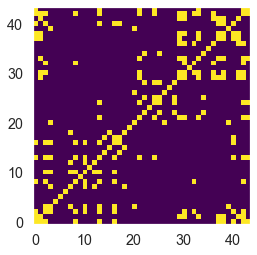

In [29]:
X_rp = RecurrencePlot().set_params(**PARAMETROS_RP).fit_transform(X)
plt.imshow(X_rp[0,:], cmap='viridis', origin='lower')
plt.grid(False)

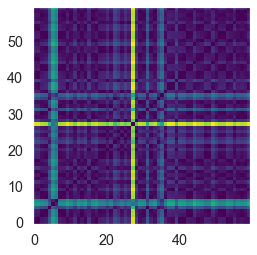

In [31]:
PARAMETROS_RP2 = {
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}
X_rp = RecurrencePlot().set_params(**PARAMETROS_RP2).fit_transform(X)
plt.imshow(X_rp[0,:], cmap='viridis', origin='lower')
plt.grid(False)

In [32]:
X_rp

array([[[0.        , 0.00582504, 0.05967903, ..., 0.0553112 ,
         0.03347778, 0.0363903 ],
        [0.00582504, 0.        , 0.06550407, ..., 0.06113625,
         0.03930283, 0.03056526],
        [0.05967903, 0.06550407, 0.        , ..., 0.00436783,
         0.02620125, 0.09606934],
        ...,
        [0.0553112 , 0.06113625, 0.00436783, ..., 0.        ,
         0.02183342, 0.09170151],
        [0.03347778, 0.03930283, 0.02620125, ..., 0.02183342,
         0.        , 0.06986809],
        [0.0363903 , 0.03056526, 0.09606934, ..., 0.09170151,
         0.06986809, 0.        ]],

       [[0.        , 0.05205345, 0.01862383, ..., 0.4054451 ,
         0.41977167, 0.39064074],
        [0.05205345, 0.        , 0.03342962, ..., 0.45749855,
         0.47182512, 0.44269419],
        [0.01862383, 0.03342962, 0.        , ..., 0.42406893,
         0.4383955 , 0.40926456],
        ...,
        [0.4054451 , 0.45749855, 0.42406893, ..., 0.        ,
         0.01432657, 0.01480436],
        [0.4

In [39]:
X_rp[0,:].min()

0.0